# SPES-Ext

In [ ]:
import pandas as pd
import numpy as np
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
import math
import copy


file_name = "./raw_data/azurefunctions-dataset2019/invocations_per_function_md.anon.d"
train_file_names, test_file_names = [file_name+"%02d.csv" % (i) for i in range(1, 13)], [file_name+"13.csv", file_name+"14.csv"]

mem_name = "./raw_data/azurefunctions-dataset2019/app_memory_percentiles.anon.d"
train_mem_names = [mem_name+"%02d.csv" % (i) for i in range(1, 13)]


In [ ]:
train_func_arrcount = {}
train_func_owner_app = {}
train_owner_func = defaultdict(set)
train_app_func = defaultdict(set)
train_func_app = {}

train_app_min = {} # func num per min per app
train_daily_avg = {} # func num per day per app

func_trigger = defaultdict(set)


max_cnt = []
for i, file in enumerate(train_file_names):
    df = pd.read_csv(file)
    
    for _, row in df.iterrows():
        func = row["HashFunction"]
        train_func_owner_app[func] = row["HashOwner"]+'\t'+row["HashApp"]
        train_owner_func[row["HashOwner"]].add(func)
        train_app_func[row["HashApp"]].add(func)
        func_trigger[func].add(row["Trigger"])
        train_func_app[func] = row["HashApp"]
        
        if func not in train_func_arrcount:
            train_func_arrcount[func] = [0]*12*1440
        train_func_arrcount[func][i*1440: (i+1)*1440] = list(row[4:].values)
        
        if row["HashApp"] not in train_app_min:
            train_app_min[row["HashApp"]] = [0]*12*1440
        for n in range(i*1440,(i+1)*1440):
            if train_func_arrcount[func][n] > 0:
                train_app_min[row["HashApp"]][n] += 1
        
        max_row = max(list(row[4:].values))
        max_cnt.append(max_row)
        # if max_row > max_cnt:
        #     max_cnt = max_row
        
    for app in train_app_min:
        if app not in train_daily_avg:
            train_daily_avg[app] = [0]*12
        # train_daily_avg[app][i] = np.mean(train_app_min[app][i*1440:(i+1)*1440])
        train_daily_avg[app][i] = np.sum(train_app_min[app][i*1440:(i+1)*1440])
            
    del df
    
print('train average function max concurrent cnt:',np.mean(max_cnt))
print('train median function max concurrent cnt:',np.median(max_cnt))
print('train max function max concurrent cnt:',max(max_cnt))

test_func_arrcount = {}
test_func_owner_app = {}
test_owner_func = defaultdict(set)
test_app_func = defaultdict(set)
test_func_app = {}

test_app_min = {} # func num per min per app
test_daily_avg = {} # func num per day per app

max_cnt = []
for i, file in enumerate(test_file_names):
    df = pd.read_csv(file)
    
    for _, row in df.iterrows():
        func = row["HashFunction"]
        test_func_owner_app[func] = row["HashOwner"]+'\t'+row["HashApp"]
        test_owner_func[row["HashOwner"]].add(func)
        test_app_func[row["HashApp"]].add(func)
        func_trigger[func].add(row["Trigger"])
        test_func_app[func] = row["HashApp"]
        
        if func not in test_func_arrcount:
            test_func_arrcount[func] = [0]*2*1440    
        test_func_arrcount[func][i*1440: (i+1)*1440] = list(row[4:].values)
            
        if row["HashApp"] not in test_app_min:
            test_app_min[row["HashApp"]] = [0]*2*1440
        for n in range(i*1440,(i+1)*1440):
            if test_func_arrcount[func][n] > 0:
                test_app_min[row["HashApp"]][n] += 1
        
        max_row = max(list(row[4:].values))
        max_cnt.append(max_row)
        # if max_row > max_cnt:
        #     max_cnt = max_row
        
    del df
    
    for app in test_app_min:
        if app not in test_daily_avg:
            test_daily_avg[app] = [0]*2
        # test_daily_avg[app][i] = np.mean(test_app_min[app][i*1440:(i+1)*1440])
        test_daily_avg[app][i] = np.sum(test_app_min[app][i*1440:(i+1)*1440])
    
print('test average function max concurrent cnt:',np.mean(max_cnt))
print('test median function max concurrent cnt:',np.median(max_cnt))
print('test max function max concurrent cnt:',max(max_cnt))
    
train_NUM, test_NUM = len(train_func_arrcount), len(test_func_arrcount)
train_NUM, test_NUM

train average function max concurrent cnt: 77.8191722850631
train median function max concurrent cnt: 1.0
train max function max concurrent cnt: 311837
test average function max concurrent cnt: 75.9001421464108
test median function max concurrent cnt: 1.0
test max function max concurrent cnt: 162127


(71616, 39388)

In [3]:
file = mem_name+"%02d.csv" % (1)
temp1=set()
df = pd.read_csv(file)
for _, row in df.iterrows():
    app = row["HashApp"]
    temp1.add(app)
print(len(temp1))

17265


In [4]:
file = file_name+"%02d.csv" % (1)
temp2=set()
df = pd.read_csv(file)
for _, row in df.iterrows():
    app = row["HashApp"]
    temp2.add(app)
print(len(temp2))

17577


In [5]:
extra = 0
for a in temp1:
    if a not in temp2:
        extra += 1
print(extra)

110


In [ ]:
train_daily_mem = {} 
train_app_mem = {} 
abn = 0

for i, file in enumerate(train_mem_names):
    df = pd.read_csv(file)
    for _, row in df.iterrows():
        app = row["HashApp"]
        if app not in train_app_mem:
            train_app_mem[app] = [0]*12
        train_app_mem[app][i] = row["AverageAllocatedMb"]
        if app not in train_daily_mem:
            train_daily_mem[app] = [0]*12
        if app in train_daily_avg:
            if train_daily_avg[app][i] == 0:
                train_daily_mem[app][i] = 0
            else:
                train_daily_mem[app][i] = row["AverageAllocatedMb"] / train_daily_avg[app][i]
    del df
        
test_daily_mem = {}
train_avg = np.mean([train_app_mem[app] for app in train_app_mem]) 
for i, file in enumerate(test_file_names):
    df = pd.read_csv(file)
    for _, row in df.iterrows():
        app = row["HashApp"]
        if app in train_daily_mem: 
            if app not in test_daily_mem:
                test_daily_mem[app] = [0]*2
            test_daily_mem[app][i] = np.mean(train_app_mem[app]) / test_daily_avg[app][i]
        else:
            if app not in test_daily_mem:
                test_daily_mem[app] = [0]*2
            test_daily_mem[app][i] = train_avg / test_daily_avg[app][i]
    del df

In [ ]:
class func_state:
    def __init__(self, _type = 0, forget = 0, mem = 0):
        self.type = _type
        self.forget = forget
        
        self.state = False 
        self.load_time = None 
        self.wait_time = None 
        self.last_call = None
        self.pre_call_start = None 
        
        self.idle_info = {} 
        self.invok_info = {}
        
        self.pred_value = []
        self.next_invok_start = []
        
        self.adp_wait = []
        
        
        self.currServer = None
        self.mem = mem
        self.running = False
    
    def load(self, load_time):
        self.state = True
        self.load_time = load_time
    
    def cal_lasting(self, cur_time):
        if not self.state:
            return 0
        return cur_time - load_time + 1
    
    def unload(self):
        self.state = False
        self.load_time = None
        
        self.currServer = None
        self.running = False
    
    def cal_wait(self):
        if self.wait_time is None:
            self.wait_time = 0
        self.wait_time += 1
    
    def reset(self, pred=False):
        self.unload()
        self.wait_time = None 
        self.last_call = None
        self.pre_call_start = None
        
        self.adp_wait = []
        
        if pred:
            self.next_invok_start = []

func_class = {}
for func in train_func_arrcount:
    func_class[func] = func_state()

In [8]:
FILL_ZERO_FLAG = True
shown_func_num = 1000
UNKNOWN, WARM, REGULAR, APPRO_REGULAR, DENSE, SUCCESSIVE, PLUSED, POSSIBLE, CORR, NEW_POSS = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 #Diviable? Active?
TYPE_NUM = 10

# Well-known Function Categorization

In [9]:
def conj_seq_lst(lst, count_invok=False, threshold=1):
    seq_lenth_lst = []
    pre_pos = -1
    for i, e in enumerate(lst):
        if not (bool(e) ^ count_invok):
            if pre_pos < 0:
                pre_pos = i
            if i == len(lst)-1 and i+1-pre_pos >= threshold:
                seq_lenth_lst.append(i+1-pre_pos)
        else:
            if pre_pos>=0 and i-pre_pos >= threshold:
                seq_lenth_lst.append(i-pre_pos)
            pre_pos = -1
    return seq_lenth_lst

In [10]:
def merge(lst):
    unique, counts = np.unique(lst, return_counts=True)
    mode = unique[np.argmax(counts)]
    if mode < 500: return lst
    if max(counts) < len(counts) / 2: return lst
    
    used = [False] * len(lst)
    new_lst = []

    for i in range(0, len(lst)):
        if lst[i] <= mode*0.25:
            continue
        else:
            cur = lst[i]
            for k in range(1, i+1):
                cur_idx = max(0, i-k)
                if lst[cur_idx] >= mode * 0.75: break
                if cur + lst[cur_idx] <= mode and lst[cur_idx] <= mode*0.25 and not used[cur_idx]:
                    used[cur_idx] = True
                    cur += lst[cur_idx]
            for k in range(1, len(lst)-i):
                cur_idx = min(len(lst)-1, i+k)
                if lst[cur_idx] >= mode * 0.75: break
                if cur + lst[cur_idx] <= mode and lst[cur_idx] <= mode*0.25 and not used[cur_idx]:
                    used[cur_idx] = True
                    cur += lst[cur_idx]
        new_lst.append(cur)
    
    if sum(used) / len(used) > 0.3:
        return lst
    
    return new_lst

### Always warm

In [11]:
always_num = 0
almost_num = 0

c = 0
with tqdm(total=train_NUM) as pbar:
    for func, arrcount in train_func_arrcount.items():
        c += 1
        if 0 not in arrcount:
            func_class[func].type = WARM
            always_num += 1
        
        elif np.count_nonzero(np.array(arrcount) == 0) < 0.001 * len(arrcount):
            func_class[func].type = WARM
            almost_num += 1
        
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)

warm_num = almost_num + always_num
almost_num, always_num

 99%|█████████▉| 71000/71616 [01:22<00:00, 863.77it/s]


(1119, 720)

### Regular

In [12]:
SEQ_NUM_BOUND = 3 #Too infrequently invoked functions should not be categorized to this type.

regu1_num, regu2_num = 0, 0 
merge_num = 0

c = 0
with tqdm(total=train_NUM) as pbar:
    for func, arrcount in train_func_arrcount.items():
        c += 1
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)
            
        if func_class[func].type >= REGULAR: 
            func_class[func].type = 0
        
        if func_class[func].type != 0: continue
            
        non_invok = conj_seq_lst(arrcount)
        invok = conj_seq_lst(arrcount, count_invok=True)
        
        if len(invok) >= SEQ_NUM_BOUND and len(non_invok) > 0:
            unique, counts = np.unique(non_invok, return_counts=True)
            mode = unique[np.argmax(counts)]
        
            if mode - non_invok[0] > 2:
                if arrcount[-1] > 0:
                    non_invok = non_invok[1:]
                else:
                    non_invok = non_invok[1:-1]
            
            if len(non_invok) > SEQ_NUM_BOUND:
                if np.percentile(non_invok, 95) - np.percentile(non_invok, 5) < 1:
                    func_class[func].type = REGULAR
                    regu1_num += 1
                elif np.std(non_invok) / np.mean(non_invok) <= 0.01:
                    func_class[func].type = REGULAR
                    regu2_num += 1
                
            ##slacking
            if FILL_ZERO_FLAG and func_class[func].type == 0:
                non_invok = merge(non_invok)
                
                if np.percentile(non_invok, 95) - np.percentile(non_invok, 5) < 1:
                    func_class[func].type = REGULAR
                    regu1_num += 1
                elif np.std(non_invok) / np.mean(non_invok) <= 0.01:
                    func_class[func].type = REGULAR
                    regu2_num += 1
                
                merge_num += (func_class[func].type == REGULAR)

        
regular_num = regu1_num + regu2_num
regular_num, regu1_num, regu2_num, merge_num

 99%|█████████▉| 71000/71616 [07:21<00:03, 160.96it/s]


(16193, 14809, 1384, 350)

### Appro Regular

In [13]:
IDLE_NUM_MAX = 3 #Consider the first n modes
IDLE_PERCEN = 0.9

appro_num = 0

c = 0
with tqdm(total=train_NUM) as pbar:
    for func, arrcount in train_func_arrcount.items():
        c += 1
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)

        if func_class[func].type >= APPRO_REGULAR:
            func_class[func].type = 0
        
        if func_class[func].type == 0:
                
            non_invok = conj_seq_lst(arrcount)
            if len(non_invok) < SEQ_NUM_BOUND: continue
            
            non_invok_unique, non_invok_counts = np.unique(non_invok, return_counts=True)
            non_mode_max_index = np.argsort(-non_invok_counts)[:IDLE_NUM_MAX]
            
            if max(non_invok_counts) > 1:#If all WT values only appear once, it's meaningless.
                if sum(non_invok_counts[non_mode_max_index]) >= sum(non_invok_counts) * IDLE_PERCEN:
                    appro_num += 1
                    func_class[func].type = APPRO_REGULAR
                    
appro_num

 99%|█████████▉| 71000/71616 [02:53<00:01, 409.97it/s]


6242

### Dense

In [14]:
DENSE_UPPER_BOUND = 5 #the small constant
DENSE_PERCEN = 90

dense_num = 0

c = 0
with tqdm(total=train_NUM) as pbar:
    for func, arrcount in train_func_arrcount.items():
        c += 1
        if func_class[func].type >= DENSE:
            func_class[func].type = 0
        
        if func_class[func].type == 0:
            non_invok = conj_seq_lst(arrcount)
            if np.percentile(non_invok, DENSE_PERCEN) < DENSE_UPPER_BOUND:
                dense_num += 1
                func_class[func].type = DENSE
        
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)

dense_num  

 99%|█████████▉| 71000/71616 [02:36<00:01, 452.90it/s]


405

### Successive

In [15]:
def cal_AN_seq(lst):
    seq_lenth_num = []
    pre_pos = -1
    for i, e in enumerate(lst):
        if bool(e):
            if pre_pos < 0:
                pre_pos = i
            if i == len(lst)-1 and i-pre_pos >= 0:
                seq_lenth_num.append(sum(lst[pre_pos:i+1]))
        else:
            if pre_pos >= 0 and i-pre_pos >= 1:
                seq_lenth_num.append(sum(lst[pre_pos:i]))
            pre_pos = -1
    return seq_lenth_num

In [16]:
gamma_1 = 10
gamma_2 = 11

successive_num = 0

c = 0
with tqdm(total=train_NUM) as pbar:
    for func, arrcount in train_func_arrcount.items():
        c += 1
        if func_class[func].type >= SUCCESSIVE:
            func_class[func].type = 0
            
        if func_class[func].type == 0:
            invok = conj_seq_lst(arrcount, count_invok=True)
            invok_seq_num = cal_AN_seq(arrcount)
            
            if min(invok) >= gamma_1 or min(invok_seq_num) >= gamma_2:
                successive_num += 1
                func_class[func].type = SUCCESSIVE
        
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)

successive_num

 99%|█████████▉| 71000/71616 [03:17<00:01, 360.32it/s]


1683

## Forgetting

In [17]:
def re_categorzing(arrcount):
    #Always warm:
    if min(arrcount) > 0: 
        return WARM, 0
    if np.count_nonzero(np.array(arrcount) == 0) < 0.001 * len(arrcount):
        return WARM, 0
    
    invok = conj_seq_lst(arrcount, count_invok=True)
    non_invok = conj_seq_lst(arrcount)
    
    if len(invok) >= SEQ_NUM_BOUND:
        non_invok_reg = [i for i in non_invok]
        if arrcount[-1] == 0: #no so-called first WT
            non_invok_reg = non_invok_reg[:-1]
            
        if np.percentile(non_invok_reg, 95) - np.percentile(non_invok_reg, 5) < 1:
            return REGULAR, 1
        if np.std(non_invok_reg) / np.mean(non_invok_reg) <= 0.01:
            return REGULAR, 2
        
        if FILL_ZERO_FLAG:
            non_invok_reg = merge(non_invok_reg)
            if np.percentile(non_invok_reg, 95) - np.percentile(non_invok_reg, 5) < 1:
                return REGULAR, 1
            if np.std(non_invok_reg) / np.mean(non_invok_reg) <= 0.01:
                return REGULAR, 2
    
        non_invok_unique, non_invok_counts = np.unique(non_invok, return_counts=True)
        non_mode_max_index = np.argsort(-non_invok_counts)[:IDLE_NUM_MAX]

        #Appro Regular     
        if max(non_invok_counts) > 1 and \
            sum(non_invok_counts[non_mode_max_index]) >= sum(non_invok_counts) * IDLE_PERCEN:
            return APPRO_REGULAR, 0
    
    if np.percentile(non_invok, DENSE_PERCEN) < DENSE_UPPER_BOUND:
        return DENSE, 0
    
    if min(invok) >= gamma_1 or min(cal_AN_seq(arrcount)) > gamma_2:
        return SUCCESSIVE, 0
    
    return UNKNOWN, 0

In [18]:
DAY = 6
change_num_day = [0] * DAY
change_num = 0

regular_type_num = [0, 0, 0]
num_per_type = [0, warm_num, regular_num, appro_num, dense_num, successive_num, 0, 0, 0, 0]

for day in range(1, DAY + 1):
    print("^"*5, "Forgetting day", day, "^"*5)
    c = 0
    with tqdm(total=train_NUM) as pbar:
        for func in train_func_arrcount:
            c += 1
            if c % shown_func_num == 0:
                pbar.update(shown_func_num)
                
            if func_class[func].forget >= day:
                func_class[func].forget = 0
                func_class[func].type = 0
            
            if func_class[func].type == 0:
                arrcount = train_func_arrcount[func][1440*day: ]

                if sum(arrcount) > 0:
                    func_class[func].type, regular_type = re_categorzing(arrcount)
                    regular_type_num[regular_type] += 1

                    if func_class[func].type > 0:
                        change_num += 1
                        change_num_day[day - 1] += 1
                        func_class[func].forget = day
                        num_per_type[func_class[func].type] += 1
    
    print(change_num_day[day-1])

print("Regular num:", regular_type_num[1], regular_type_num[2])
num_per_type[0] = len(train_func_arrcount) - sum(num_per_type) #Unknown
change_num, "***", num_per_type[: SUCCESSIVE+1]

^^^^^ Forgetting day 1 ^^^^^


 99%|█████████▉| 71000/71616 [06:18<00:03, 187.75it/s]


169
^^^^^ Forgetting day 2 ^^^^^


 99%|█████████▉| 71000/71616 [05:31<00:02, 214.15it/s]


171
^^^^^ Forgetting day 3 ^^^^^


 99%|█████████▉| 71000/71616 [04:50<00:02, 244.16it/s]


218
^^^^^ Forgetting day 4 ^^^^^


 99%|█████████▉| 71000/71616 [04:08<00:02, 286.25it/s]


230
^^^^^ Forgetting day 5 ^^^^^


 99%|█████████▉| 71000/71616 [03:29<00:01, 339.29it/s]


269
^^^^^ Forgetting day 6 ^^^^^


 99%|█████████▉| 71000/71616 [02:57<00:01, 399.91it/s]

92
Regular num: 97 86


(1149, '***', [44105, 1860, 16376, 6756, 478, 2041])

## Show & Save

In [19]:
pie_count = [0] * 6
before_forget_pie_count = [0] * 6

c = 0
with tqdm(total=train_NUM) as pbar:
    for func, arrcount in train_func_arrcount.items():
        c += 1
        if func_class[func].type >= PLUSED:
            func_class[func].type = 0
            
        pie_count[func_class[func].type] += 1
        
        if func_class[func].forget > 0:
            before_forget_pie_count[0] += 1
        else:
            before_forget_pie_count[func_class[func].type] += 1
        
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)

pie_count[0]

 99%|█████████▉| 71000/71616 [00:00<00:00, 1239900.51it/s]


44105

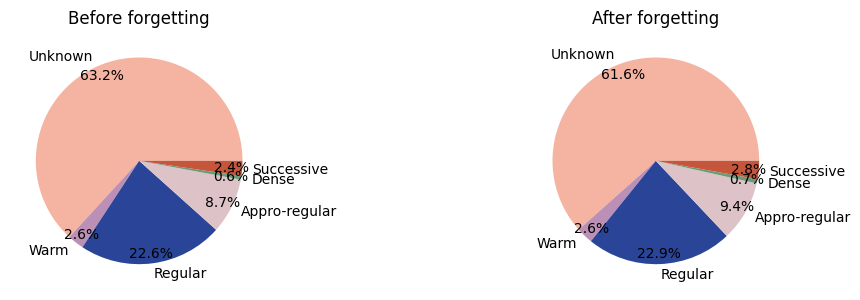

In [20]:
label_lst = ['Unknown','Warm', 'Regular', "Appro-regular", "Dense", "Successive"]
color_lst = ['#F5B3A2','#BC90B6','#2A4597','#DDC3C7', '#6A9C79', '#C5563B',"#F1AB3D", '#58A0A4','#E5F1E5',"#FBDEAF"]


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
plt.subplots_adjust(wspace=1, hspace =0)

ax1.pie(np.array(before_forget_pie_count),
        labels = label_lst,
        colors = color_lst[:6],
        #explode = [0, 0.2, 0, 0, 0.7, 0, 0.1],
        autopct='%.1f%%',
        pctdistance=0.9,
       )
ax1.set_title('Before forgetting')

ax2.pie(np.array(pie_count),
        labels = label_lst,
        colors = color_lst[:6],
        #explode = [0, 0.2, 0, 0, 0.7, 0, 0.1],
        autopct='%.1f%%',
        pctdistance=0.9,
       )
ax2.set_title('After forgetting')

plt.show()

In [21]:
#Save categorization
import os
os.makedirs("mid-data", exist_ok=True)
with open("mid-data/train_info.txt", "w") as wf:
    for func, state in func_class.items():
        wf.write(func+'\t'+str(state.type)+'\t'+str(state.forget)+'\n')

In [22]:
#Save for calculating correlations

with open("mid-data/cal_corr/to_cal_corr.txt", "w") as wf:
    for func, arrcount in train_func_arrcount.items():
        wf.write(func+'\t'+str(func_class[func].forget)+'\t'+','.join(str(a) for a in arrcount)+'\n')

In [23]:
to_cal_corr_num = 0
with open("mid-data/cal_corr/unknown_ownerapp_lst.txt", "w") as wf:
    for func, state in func_class.items():
        if state.type == 0:
            [owner, app] = train_func_owner_app[func].split('\t')
            ownerapp_lst = (train_owner_func[owner] | train_app_func[app])
            ownerapp_lst.remove(func)
            if len(ownerapp_lst) > 0:
                to_cal_corr_num += 1
                wf.write(func+'\t'+','.join(list(ownerapp_lst))+'\n')
to_cal_corr_num

40953

## Indeterminte Function Assignment

In [24]:
valid_split_DAY = 9
func_valid_res = {func: {"cold": [20000]*3, "waste": [20000]*3} 
                  for func in train_func_arrcount 
                  if func_class[func].type >= PLUSED or func_class[func].type == 0
                 }

### Plused

In [25]:
PLUSED_GIVEUP = 3
useless_num = 0
takein_assign_num = 0

c = 0
with tqdm(total=train_NUM) as pbar:
    for func, arr in train_func_arrcount.items():
        c += 1
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)
        
        if func_class[func].type >= PLUSED:
            func_class[func].type = 0
        if func_class[func].type != 0: continue
    
        valid_arr = arr[1440*valid_split_DAY: ]
        waste, used = 0, np.count_nonzero(valid_arr)
        cold_num, invok_num = 0, sum(valid_arr)
        
        if invok_num <= 0: 
            useless_num += 1
            continue
        
        takein_assign_num += 1
        
        state = False
        for i, cur_invok in enumerate(valid_arr):
            if cur_invok > 0:
                if not state:
                    state = True
                    cold_num += 1
            elif state:
                waste += 1
                if sum(valid_arr[max(0, i+1-PLUSED_GIVEUP): i]) == 0:
                    state = False
            
            func_valid_res[func]["cold"][0], func_valid_res[func]["waste"][0] = cold_num/invok_num, waste/used

useless_num, takein_assign_num  

 99%|█████████▉| 71000/71616 [01:01<00:00, 1158.21it/s]


(13271, 30834)

### Possible

In [26]:
PRE_WARM = 2
POSS_GIVEUP = 1
DISCRETE_TH = 10

takein_poss_num = 0
possible = set()

c = 0
with tqdm(total=train_NUM) as pbar:
    for func, arr in train_func_arrcount.items():
        c += 1
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)
        
        if func_class[func].type >= POSSIBLE:
            func_class[func].type = 0
            
        if func_class[func].type != 0: continue
        train_arr, valid_arr = arr[:1440 * valid_split_DAY], arr[1440 * valid_split_DAY:]
        
        waste, used = 0, np.count_nonzero(valid_arr)
        cold_num, invok_num = 0, sum(valid_arr)
        
        non_invok = conj_seq_lst(arr)
        non_invok_unique, non_invok_counts = np.unique(non_invok, return_counts=True)
        
        if invok_num == 0: 
            if max(non_invok_counts) >= 2:
                possible.add(func)
            continue
        if max(non_invok_counts) < 2: continue
        
        takein_poss_num += 1
        state = False
        ############## Calculate ##############
        cut = min(5, sum(np.where(non_invok_counts > 1, 1, 0)))
        non_mode_max_index = np.argsort(-non_invok_counts)[:cut]
        modes = non_invok_unique[non_mode_max_index]
        
        if max(modes) - min(modes) <= DISCRETE_TH:
            pred_value = [min(modes), max(modes)]
            pred_value_discrete = False
        else:
            pred_value = sorted(list(modes))
            pred_value_discrete = True
        
        ############## Calculate ##############
        
        
        next_invok_start = []
        wait_time = 1440 * valid_split_DAY
        
        ############## Prewarming at time 0 ##############
        if np.count_nonzero(train_arr) > 0:
            last_call = np.where(np.array(train_arr) > 0)[0][-1] - len(train_arr)
            wait_time = non_invok[-1] if train_arr[-1] == 0 else 0
            if pred_value_discrete:
                next_invok_start = [(last_call + p + 1, last_call + p + 1) for p in pred_value]
            else:
                next_invok_start = [(last_call + pred_value[0] + 1, last_call + pred_value[1] + 1)]
        
            if train_arr[-1] > 0: state = True

        for (left, right) in next_invok_start:
            if left <= PRE_WARM and right >= -PRE_WARM:
                state = True
                break
        ############## Prewarming at time 0 ##############
        
        
        for i, cur_invok in enumerate(valid_arr):
            if cur_invok > 0:
                if not state:
                    state = True
                    cold_num += 1
                
                last_call = i
                wait_time = 0
                if pred_value_discrete:
                    next_invok_start = [(i + p + 1, i + p + 1) for p in pred_value]
                else:
                    next_invok_start = [(i + pred_value[0] + 1, i + pred_value[1] + 1)]
            else:
                wait_time += 1
                pre_warm_flag = False
                for (left, right) in next_invok_start:
                    if left <= i + PRE_WARM and right >= i - PRE_WARM:
                        pre_warm_flag = True
                        break      
                if state:
                    waste += 1
                    if (not pre_warm_flag) and wait_time >= POSS_GIVEUP:
                        state = False
                elif pre_warm_flag:
                    state = True
        
        func_valid_res[func]["cold"][1], func_valid_res[func]["waste"][1] = cold_num/invok_num, waste/used

takein_poss_num

 99%|█████████▉| 71000/71616 [04:28<00:02, 264.46it/s]


22067

### Correlated

#### Load Connections

In [27]:
import os 
import json
def read_json(filepath):
    if os.path.exists(filepath):
        assert filepath.endswith('.json')
        with open(filepath, 'r') as f:
            return json.loads(f.read())
    else: 
        print("File path "+filepath+" not exists!")
        return

train_candi = read_json("mid-data/func_candi.json")
    
len(train_candi)

27123

#### Calculate the predictive values of candidate functions

In [28]:
candi_pred_value = defaultdict(list)

c = 0
with tqdm(total=len(train_candi)) as pbar:
    for _, tri_tuple_lst in train_candi.items():
        c += 1
        if c % (shown_func_num) == 0:
            pbar.update(shown_func_num)
        
        for (candi_func, _, _) in tri_tuple_lst:
            if candi_func in candi_pred_value: continue
            
            arrcount = train_func_arrcount[candi_func][1440*func_class[candi_func].forget:]
            non_invok = conj_seq_lst(arrcount)

            if func_class[candi_func].type == REGULAR: 
                candi_pred_value[candi_func] = [np.median(non_invok)]

            elif func_class[candi_func].type in [APPRO_REGULAR, DENSE]:
                non_invok_unique, non_invok_counts = np.unique(non_invok, return_counts=True)
                non_mode_max_index = np.argsort(-non_invok_counts)[: min(5, sum(np.where(non_invok_counts > 1, 1, 0)))]
                
                if func_class[candi_func].type == APPRO_REGULAR:
                    candi_pred_value[candi_func] = non_invok_unique[non_mode_max_index[: min(len(non_mode_max_index), IDLE_NUM_MAX)]].tolist()

                elif func_class[candi_func].type == DENSE:
                    if len(non_mode_max_index) > 0:
                        candi_pred_value[candi_func] = [min(non_invok_unique[non_mode_max_index]), 
                                                        min(DENSE_UPPER_BOUND, max(non_invok_unique[non_mode_max_index]))]
                    else:
                        candi_pred_value[candi_func] = [min(non_invok_unique), min(DENSE_UPPER_BOUND, max(non_invok_unique))]       


100%|█████████▉| 27000/27123 [07:32<00:02, 59.67it/s]


#### Calculate the last call of candidate functions at each time i

In [29]:
candi_last_call_dict = {}

c = 0
with tqdm(total=len(train_candi)) as pbar:
    for _, tri_tuple_lst in train_candi.items():
        c += 1
        if c % (shown_func_num) == 0:
            pbar.update(shown_func_num)
        
        for (candi_func, _, _) in tri_tuple_lst:
            if candi_func in candi_last_call_dict: continue
            
            candi_func_arrcount = train_func_arrcount[candi_func][: 1440 * valid_split_DAY]
            if max(candi_func_arrcount) > 0:
                last_call = np.where(np.array(candi_func_arrcount) > 0)[0][-1] - len(candi_func_arrcount)
            else:
                last_call = None
            
            valid_arr = train_func_arrcount[candi_func][1440 * valid_split_DAY: ]
            candi_last_call_dict[candi_func] = [None] * len(valid_arr)
            
            for i, cur_invok in enumerate(valid_arr):
                if cur_invok > 0:
                    last_call = i
                    candi_last_call_dict[candi_func][i] = i
                else:
                    candi_last_call_dict[candi_func][i] = last_call

100%|█████████▉| 27000/27123 [00:50<00:00, 536.68it/s] 


#### Run correlated validation

In [30]:
CORR_GIVEUP = 1

takein_corr_num = 0

c = 0
with tqdm(total=len(train_candi)) as pbar:
    for func, tri_tuple_lst in train_candi.items():
        c += 1
        if c % (shown_func_num/10) == 0:
            pbar.update(shown_func_num/10)
        
        if func_class[func].type >= CORR:
            func_class[func].type = 0
            
        if func_class[func].type != 0: continue
        
        train_arr, valid_arr = train_func_arrcount[func][:1440*valid_split_DAY], train_func_arrcount[func][1440*valid_split_DAY:]
        waste, used = 0, np.count_nonzero(valid_arr)
        cold_num, invok_num = 0, sum(valid_arr)
        if invok_num <= 0: continue
        
        takein_corr_num += 1
        
        next_invok_start = []
        ############## Calculate next_invok_start at time 0 ##############
        for (candi_func, lag, _) in tri_tuple_lst:
           
            candi_func_arrcount = train_func_arrcount[candi_func][: 1440 * valid_split_DAY]
            
            if np.count_nonzero(candi_func_arrcount) > 0:
                candi_last_call = np.where(np.array(candi_func_arrcount) > 0)[0][-1] - len(candi_func_arrcount)
                next_invok_start += [(candi_last_call, candi_last_call + lag)]

                if func_class[candi_func].type in [REGULAR, APPRO_REGULAR]:
                    next_invok_start += [(candi_last_call + 1 + p, candi_last_call + 1 + p + lag) 
                                           for p in candi_pred_value[candi_func]]
                elif func_class[candi_func].type == DENSE:
                    next_invok_start += [(candi_last_call + 1 + candi_pred_value[candi_func][0], 
                                            candi_last_call + 1 + candi_pred_value[candi_func][1] + lag)]
        
        ############## Calculate next_invok_start at time 0 ##############
        
        state = False
        wait_time = 1440 * valid_split_DAY
        
        ############## Prewarming at time 0 ##############
        if np.count_nonzero(train_arr) > 0:
            last_call = np.where(np.array(train_arr) > 0)[0][-1] - len(train_arr)
            wait_time = non_invok[-1] if train_arr[-1] == 0 else 0
            if train_arr[-1] > 0: state = True
        
        for (left, right) in next_invok_start:
            if left <= PRE_WARM and right >= -PRE_WARM:
                state = True
                break
        ############## Prewarming at time 0 ##############
        
        for i, cur_invok in enumerate(valid_arr):
            next_invok_start = []
            for (candi_func, lag, _) in tri_tuple_lst:
                if candi_last_call_dict[candi_func][i] is not None:
                    candi_last_call = candi_last_call_dict[candi_func][i]
                    next_invok_start += [(candi_last_call, candi_last_call + lag)]

                    if func_class[candi_func].type in [REGULAR, APPRO_REGULAR]:
                        next_invok_start += [(candi_last_call + 1 + p, candi_last_call + 1 + p + lag) 
                                               for p in candi_pred_value[candi_func]]

                    elif func_class[candi_func].type == DENSE:
                        next_invok_start += [(candi_last_call + 1 + candi_pred_value[candi_func][0], 
                                            candi_last_call + 1 + candi_pred_value[candi_func][1] + lag)]

            if cur_invok > 0:
                if not state:
                    state = True
                    cold_num += 1
                wait_time = 0
            
            else:
                wait_time += 1
                pre_warm_flag = False
                for (left, right) in next_invok_start:
                    if left <= i + PRE_WARM and right >= i - PRE_WARM:
                        pre_warm_flag = True
                        break

                if state:
                    waste += 1
                    if (not pre_warm_flag) and wait_time >= CORR_GIVEUP:
                        state = False
                elif pre_warm_flag:
                    state = True
                
        func_valid_res[func]["cold"][2], func_valid_res[func]["waste"][2] = cold_num/invok_num, waste/used

takein_corr_num

100%|█████████▉| 27100.0/27123 [11:11<00:00, 40.37it/s]


17923

### Assignment

In [31]:
alpha = 0.5

final_res = {}
good_assign_num, unknown_valid_num, bad_assign_num = 0, 0, 0
force_assign = [0] * 3


for func, res in func_valid_res.items():
    if min(res["cold"]) < 20000:
        
        cold_idx, waste_idx = np.argmin(res["cold"]), np.argmin(res["waste"])

        if cold_idx == waste_idx and res["cold"][cold_idx] < 1:
            final_res[func] = cold_idx
            good_assign_num += 1

        else:
            if cold_idx < waste_idx and res["cold"][cold_idx] == res["cold"][waste_idx]: #same cold, choose the smaller waste
                final_res[func] = waste_idx
                good_assign_num += 1
            elif waste_idx < cold_idx and res["waste"][cold_idx] == res["waste"][waste_idx]:
                final_res[func] = cold_idx
                good_assign_num += 1

            elif res["cold"][cold_idx] <= 0.1: #avoid zero division
                final_res[func] = cold_idx

            elif res["cold"][cold_idx] == 1:
                bad_assign_num += 1
                if func in possible:
                    final_res[func] = 1
                else:
                    final_res[func] = 0

            else:
                if func in possible:
                    final_res[func] = 1
                else:
                    delta_cold = alpha * (res["cold"][waste_idx] - res["cold"][cold_idx])/res["cold"][cold_idx]
                    delta_waste = (res["waste"][cold_idx] - res["waste"][waste_idx])/res["waste"][waste_idx]
                    if delta_cold <= delta_waste:
                        final_res[func] = cold_idx
                    else:
                        final_res[func] = waste_idx   

                force_assign[final_res[func]] += 1
    else:
        if func in possible:
            final_res[func] = 1
        else:
            unknown_valid_num += 1
        continue

for func, idx in final_res.items():
    func_class[func].type = PLUSED+idx

print(f"{len(final_res)} of the {pie_count[0]}, {len(func_valid_res)} unknown functions are assigned.") #len(final_res) + unknown_valid_num == pie_count[0]
print(f"{unknown_valid_num}/{useless_num} functions don't fit any of the three rules.")
print(takein_assign_num, takein_poss_num, takein_corr_num, "functions are tried to fit for the three rules.")
print(f"{good_assign_num} functions are assigned smoothly.")
print(f"{bad_assign_num} functions are assigned with a bad grace.")
print(f"{sum(force_assign)} functions are assigned forcibly: {force_assign[0]} are plused, {force_assign[1]} are possible, and {force_assign[2]} are CORR.")

33882 of the 44105, 44105 unknown functions are assigned.
10223/13271 functions don't fit any of the three rules.
30834 22067 17923 functions are tried to fit for the three rules.
4870 functions are assigned smoothly.
3552 functions are assigned with a bad grace.
10343 functions are assigned forcibly: 857 are plused, 7488 are possible, and 1998 are CORR.


In [32]:
cold_ratio = [func_valid_res[func]["cold"][idx] for func, idx in final_res.items()]
waste_ratio = [func_valid_res[func]["waste"][idx] for func, idx in final_res.items()]
np.percentile(cold_ratio, 75), np.median(waste_ratio), np.percentile(waste_ratio, 75)

(0.7, 4.6680163592517765, 15.22072072072072)

### Record Corr candidate functions

In [33]:
candi_func_tuplelst = defaultdict(list)
all_corr_candi_num = 0

candi_dist = [0] * TYPE_NUM

for func, tri_tuple_lst in train_candi.items():
    if func_class[func].type == CORR:
        func_all_corr_candi = True
    
        for (candi, lag, _) in tri_tuple_lst:
            if candi not in candi_func_tuplelst:
                candi_dist[func_class[candi].type] += 1
                
            candi_func_tuplelst[candi].append((func, lag))
            if func_class[candi].type != CORR:
                func_all_corr_candi = False
    
        all_corr_candi_num += func_all_corr_candi

all_corr_candi_num

374

## Show & Save

In [34]:
pie_count = [0] * (TYPE_NUM - 1)
before_forget_pie_count = [0] * (TYPE_NUM - 1)

c = 0
with tqdm(total=train_NUM) as pbar:
    for func, arrcount in train_func_arrcount.items():
        c += 1
        if func_class[func].type > CORR:
            func_class[func].type = 0
            
        pie_count[func_class[func].type] += 1
        
        if func_class[func].forget > 0:
            before_forget_pie_count[0] += 1
        else:
            before_forget_pie_count[func_class[func].type] += 1
        
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)

pie_count[0]

 99%|█████████▉| 71000/71616 [00:00<00:00, 1149843.17it/s]


10223

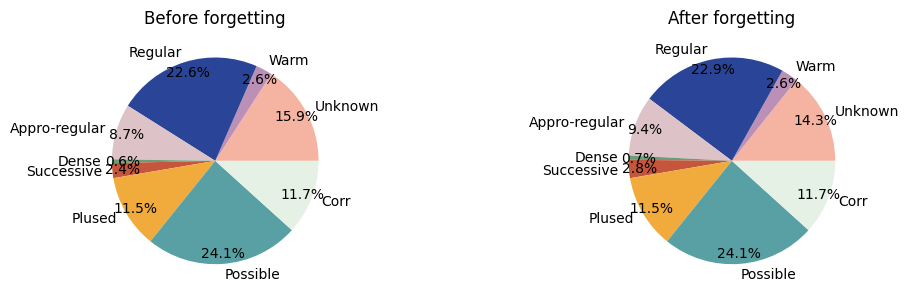

In [35]:
label_lst = ['Unknown','Warm', 'Regular', "Appro-regular", "Dense", "Successive", "Plused", "Possible", "Corr"]
color_lst = ['#F5B3A2','#BC90B6','#2A4597','#DDC3C7', '#6A9C79', '#C5563B',"#F1AB3D", '#58A0A4','#E5F1E5',"#FBDEAF"]


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
plt.subplots_adjust(wspace=1, hspace =0)

ax1.pie(np.array(before_forget_pie_count),
        labels = label_lst,
        colors = color_lst[:TYPE_NUM-1],
        #explode = [0, 0.2, 0, 0, 0.7, 0, 0.1],
        autopct='%.1f%%',
        pctdistance=0.9,
       )
ax1.set_title('Before forgetting')

ax2.pie(np.array(pie_count),
        labels = label_lst,
        colors = color_lst[:TYPE_NUM-1],
        #explode = [0, 0.2, 0, 0, 0.7, 0, 0.1],
        autopct='%.1f%%',
        pctdistance=0.9,
       )
ax2.set_title('After forgetting')

plt.show()

#### Save categorization

In [36]:
os.makedirs("mid-data", exist_ok=True)
with open("mid-data/train_info_assigned.txt", "w") as wf:
    for func, state in func_class.items():
        wf.write(func+'\t'+str(state.type)+'\t'+str(state.forget)+'\n')

# Provision

### Calculate basic info

In [37]:
additional_poss_num = 0

c = 0
with tqdm(total=train_NUM) as pbar:
    for func in train_func_arrcount:
        func_class[func].reset(True)
        c += 1
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)
            
        if func_class[func].type == WARM: continue
            
        func_class[func].pred_interval = [] #pred_value

        arrcount = train_func_arrcount[func][1440*func_class[func].forget:]
        func_class[func].last_call = np.where(np.array(arrcount)>0)[0][-1] - len(arrcount)
        #assert func_class[func].last_call < 0

        invok = conj_seq_lst(arrcount, count_invok=True)
        non_invok = conj_seq_lst(arrcount)

        func_class[func].wait_time = non_invok[-1] if arrcount[-1] == 0 else 0
        func_class[func].pre_call_start = func_class[func].last_call - invok[-1] + 1

        func_class[func].lasting_info = {"max": np.max(invok), "seq_num": len(invok)}
        func_class[func].idle_info = {"max": np.max(non_invok), "std": np.std(non_invok), "kind": len(set(non_invok))}
        
        if func_class[func].type == REGULAR:
            func_class[func].pred_interval = [np.median(non_invok)]
        
        else:
            non_invok_unique, non_invok_counts = np.unique(non_invok, return_counts=True)
            mode_cut = min(5, sum(np.where(non_invok_counts > 1, 1, 0)))
            ordered_index = np.argsort(-non_invok_counts)
            non_mode_max_index = ordered_index[: mode_cut]
            
            func_class[func].idle_info["mode"] = non_invok_unique[non_mode_max_index].tolist() #In the order of occuring count
            func_class[func].idle_info["mode_count"] = non_invok_counts[non_mode_max_index].tolist()

            if func_class[func].type == APPRO_REGULAR:
                #func_class[func].pred_interval = non_invok_unique[ordered_index[: min(len(ordered_index), IDLE_NUM_MAX)]].tolist()
                func_class[func].pred_interval = [non_invok_unique[idx] for idx in ordered_index[: min(len(ordered_index), IDLE_NUM_MAX)]
                                                                        if non_invok_counts[idx] > 0.1 * sum(non_invok_counts)]
                        
            elif func_class[func].type == DENSE:
                if len(non_mode_max_index) > 0:
                    func_class[func].pred_interval = [min(func_class[func].idle_info["mode"]),
                        min(10, max(func_class[func].idle_info["mode"]))]
                else:
                    func_class[func].pred_interval = [min(non_invok_unique), min(IDLE_NUM_MAX, max(non_invok_unique))]
            
            elif func_class[func].type == NEW_POSS:
                func_class[func].type = 0
            
            if func_class[func].type == POSSIBLE or (func_class[func].type == UNKNOWN and len(non_mode_max_index) > 0):
                additional_poss_num += (func_class[func].type == UNKNOWN)
                func_class[func].type = POSSIBLE
                if max(func_class[func].idle_info["mode"]) - min(func_class[func].idle_info["mode"]) <= DISCRETE_TH:
                    func_class[func].pred_interval = [min(func_class[func].idle_info["mode"]), 
                                                      max(func_class[func].idle_info["mode"])]
                    func_class[func].idle_info["pred_interval_discrete"] = False
                else: 
                    func_class[func].pred_interval = sorted(list(func_class[func].idle_info["mode"]))
                    func_class[func].idle_info["pred_interval_discrete"] = True


additional_poss_num

 99%|█████████▉| 71000/71616 [08:26<00:04, 140.28it/s]


0

### Rank func & Load simulating corr & Reset

#### Rank

In [38]:
func_lst, func_corr_lst = set(), set()

for func in func_class:
    if func_class[func].type == CORR:
        func_corr_lst.add(func)
    else:
        func_lst.add(func)

for func in test_func_arrcount:
    if func in func_class: continue
    func_lst.add(func)
    func_class[func] = func_state()

func_lst, func_corr_lst = list(func_lst), list(func_corr_lst)

# func_lst.sort()
# func_corr_lst.sort()

len(func_class), len(func_lst)+len(func_corr_lst)

(72359, 72359)

#### Load simulating corrlations

In [39]:
test_func_corr = defaultdict(set)

for func, ownerapp in test_func_owner_app.items():
    if func not in train_func_arrcount:
        owner, app = ownerapp.split('\t')
        candi_func_set = (test_owner_func[owner] | test_app_func[app])
        if len(candi_func_set) == 1: continue
        
        candi_func_set.remove(func)
        for candi_func in candi_func_set:
            if len(func_trigger[func] & func_trigger[candi_func]) > 0:
                test_func_corr[func].add(candi_func)

test_func_corr_perform = {func: {candi_func: 0} for candi_func in test_func_corr[func]}

#### Reset

In [40]:
for func in test_func_arrcount:
    if func in func_class and (func not in train_func_arrcount):
        del func_class[func]
    if func not in func_class:
        func_class[func] = func_state()

In [41]:
c = 0
with tqdm(total=train_NUM) as pbar:
    for func in train_func_arrcount:
        func_class[func].reset(True)
        c += 1
        if c % shown_func_num == 0:
            pbar.update(shown_func_num)
            
        if func_class[func].type == WARM: continue
        arrcount = train_func_arrcount[func][1440*func_class[func].forget:]
        func_class[func].last_call = np.where(np.array(arrcount)>0)[0][-1] - len(arrcount)
        invok = conj_seq_lst(arrcount, count_invok=True)
        non_invok = conj_seq_lst(arrcount)

        func_class[func].wait_time = non_invok[-1] if arrcount[-1] == 0 else 0
        func_class[func].pre_call_start = func_class[func].last_call - invok[-1] + 1

 99%|█████████▉| 71000/71616 [07:42<00:04, 153.52it/s]


## Calculate predictive values & predictions at time 0

In [42]:
PRE_WARM = 2
EN_STD = 2

GIVE_UP = {
    UNKNOWN: POSS_GIVEUP,
    WARM: 1440 * 14,
    REGULAR: 1,
    APPRO_REGULAR: 1,
    DENSE: DENSE_UPPER_BOUND,
    SUCCESSIVE: 1,
    PLUSED: PLUSED_GIVEUP,
    POSSIBLE: POSS_GIVEUP,
    CORR: CORR_GIVEUP,
    NEW_POSS: POSS_GIVEUP,
}

#### Predictive values

In [43]:
for func in train_func_arrcount: # calculate next invok start at time 0
    _type = func_class[func].type

    if _type == REGULAR: 
        p = func_class[func].last_call + 1
        if p < 0:
            p += (func_class[func].pred_interval[0] + 1)
        func_class[func].next_invok_start = [(p - min(func_class[func].idle_info["std"], EN_STD), 
                                              p + min(func_class[func].idle_info["std"], EN_STD))]

    elif _type == APPRO_REGULAR:
        func_class[func].next_invok_start = [(func_class[func].last_call + p + 1, func_class[func].last_call + p + 1) 
                                                 for p in func_class[func].pred_interval]
    elif _type == DENSE: 
        func_class[func].next_invok_start = [(func_class[func].last_call+func_class[func].pred_interval[0]+1,
                                             func_class[func].last_call+func_class[func].pred_interval[1]+1)]
    elif _type == CORR:
        func_class[func].next_invok_start = defaultdict(list)
        for (candi_func, lag, _ ) in train_candi[func]:
            func_class[func].next_invok_start[candi_func].append(
                (func_class[candi_func].last_call, func_class[candi_func].last_call + lag)
            )
            if func_class[candi_func].type != CORR: #otherwise, endless loop
                func_class[func].next_invok_start[candi_func] += [(nis[0], nis[1] + lag) for nis in func_class[candi_func].next_invok_start]

    elif _type in [POSSIBLE, NEW_POSS]:
        if func_class[func].idle_info["pred_interval_discrete"]:
            func_class[func].next_invok_start = [(func_class[func].last_call + p + 1, func_class[func].last_call + p + 1) 
                                                       for p in func_class[func].pred_interval]
        else:
            func_class[func].next_invok_start = [(func_class[func].last_call+func_class[func].pred_interval[0]+1,
                                            func_class[func].last_call+func_class[func].pred_interval[1]+1)]
    

#### Initialize memory

In [ ]:
memory = set()

class server_state:
    def __init__(self, maxSize = 4096, currSpace = 4096):
        self.maxSize = maxSize
        self.currSpace = currSpace
        self.pool = []
    
    def canLoad(self,newSize):
        if self.currSpace >= newSize:
            return True
        return False
    
    def load(self,func):
        self.pool.append(func)
        self.currSpace -= func_class[func].mem
        
    def unload(self,func):
        if func in self.pool:
            del self.pool[self.pool.index(func)]
            self.currSpace += func_class[func].mem
        
    def evict(self,load_func):
        global memory
        needSpace = func_class[load_func].mem - self.currSpace
        evictSpace = 0
        evict_lst = []
        for i in range(0,len(self.pool)):
            evict_func = self.pool[i]
            if not func_class[evict_func].state:
                print(evict_func)
            if func_class[evict_func].running:
                continue
            evict_lst.append(evict_func)
            evictSpace += func_class[evict_func].mem
            if evictSpace >= needSpace:
                break
        if evictSpace >= needSpace:
            for f in evict_lst:
                del self.pool[self.pool.index(f)]
                self.currSpace += func_class[f].mem
                func_class[f].unload()
                memory.remove(f)
            return True
        else:
            return False


In [ ]:
server_cnt = 6
server_lst = []


hist_mem = [0]*1440*12
train_avg_mem_daily = np.mean([train_app_mem[app] for app in train_app_mem],axis=0) 

for i, file in enumerate(train_file_names):
    df = pd.read_csv(file)
    
    for _, row in df.iterrows():
        func = row["HashFunction"]
        app = row["HashApp"]
        
        for n in range(i*1440,(i+1)*1440):
            if train_func_arrcount[func][n] > 0:
                if app in train_daily_mem:
                    hist_mem[n] += train_daily_mem[app][i]
                else:
                    hist_mem[n] += train_avg_mem_daily[i] / train_daily_avg[app][i]
                    
max_hist_mem = max(hist_mem)

server_mem = math.ceil(max_hist_mem * 1.1 / 1024 / server_cnt) * 1024

print('max_hist_mem:',max_hist_mem)
print('server_mem:',server_mem)


for i in range(0,server_cnt):
    s = server_state(maxSize = server_mem, currSpace = server_mem)
    server_lst.append(s)
    
space_lst = [server_mem] * server_cnt
round_idx = 0
evict_num = 0

max_hist_mem: 65573.72765836143
server_mem: 12288


In [ ]:
def load_server(policy,func):
    global space_lst
    global round_idx
    global evict_num
    
    
    if policy == 'Least_Loaded':
        sorted_id = sorted(range(len(space_lst)), key=lambda k: space_lst[k], reverse=True)
        min_rank = 0
        server_idx = sorted_id[min_rank]
        target_server = server_lst[server_idx]
        least_flag = True
        
        if target_server.canLoad(func_class[func].mem):
            target_server.load(func)
            func_class[func].currServer = target_server
            
        else:
            while least_flag and (not target_server.canLoad(func_class[func].mem)):
                min_rank = (min_rank+1)%server_cnt
                server_idx = sorted_id[min_rank]
                target_server = server_lst[server_idx]
                if min_rank == 0:
                    if target_server.evict(func):
                        evict_num += 1
                    else:     
                        min_rank = (min_rank+1)%server_cnt
                        server_idx = sorted_id[min_rank]
                        target_server = server_lst[server_idx]
                        while not target_server.evict(func):
                            min_rank = (min_rank+1)%server_cnt
                            server_idx = sorted_id[min_rank]
                            target_server = server_lst[server_idx]
                            if min_rank == 0: 
                                print('Out of max memory,you need to queue!')
                                print('func mem:',func_class[func].mem,'space_lst',space_lst)
                                least_flag = False
                                break
                        if least_flag:
                            evict_num += 1
            if least_flag:
                target_server.load(func)
                func_class[func].currServer = target_server
        space_lst = [s.currSpace for s in server_lst]
        return least_flag            
    
    
    elif policy ==  'Greedy':
        sorted_id = sorted(range(len(space_lst)), key=lambda k: space_lst[k], reverse=False)
        max_rank = 0
        server_idx = sorted_id[max_rank]
        target_server = server_lst[server_idx]
        # orig_idx = server_idx
        greedy_flag = True
        
        if target_server.canLoad(func_class[func].mem):
            target_server.load(func)
            func_class[func].currServer = target_server
            
        else:
            while greedy_flag and (not target_server.canLoad(func_class[func].mem)):
                max_rank = (max_rank+1)%server_cnt
                server_idx = sorted_id[max_rank]
                target_server = server_lst[server_idx]
                if max_rank == 0:
                    if target_server.evict(func):
                        evict_num += 1
                    else:     
                        max_rank = (max_rank+1)%server_cnt
                        server_idx = sorted_id[max_rank]
                        target_server = server_lst[server_idx]
                        while not target_server.evict(func):
                            max_rank = (max_rank+1)%server_cnt
                            server_idx = sorted_id[max_rank]
                            target_server = server_lst[server_idx]
                            if max_rank == 0: 
                                print('Out of max memory,you need to queue!')
                                print('func mem:',func_class[func].mem,'space_lst',space_lst)
                                greedy_flag = False
                                break
                        if greedy_flag:
                            evict_num += 1
            if greedy_flag:
                target_server.load(func)
                func_class[func].currServer = target_server
        space_lst = [s.currSpace for s in server_lst]
        return greedy_flag
    
        
    elif policy == 'Hash':
        server_idx = hash(func)%server_cnt
        target_server = server_lst[server_idx]
        orig_idx = server_idx
        hash_flag = True
        
        if target_server.canLoad(func_class[func].mem):
            target_server.load(func)
            func_class[func].currServer = target_server
            
        else:
            while hash_flag and (not target_server.canLoad(func_class[func].mem)):
                server_idx = (server_idx+1)%server_cnt
                target_server = server_lst[server_idx]
                if server_idx == orig_idx:
                    if target_server.evict(func):
                        evict_num += 1
                    else:
                        server_idx = (server_idx+1)%server_cnt
                        target_server = server_lst[server_idx]
                        while not target_server.evict(func):
                            server_idx = (server_idx+1)%server_cnt
                            target_server = server_lst[server_idx]
                            if server_idx == orig_idx: 
                                print('Out of max memory,you need to queue!')
                                print('func mem:',func_class[func].mem,'space_lst',space_lst)
                                hash_flag = False
                                break
                        if hash_flag:
                            evict_num += 1
            if hash_flag:
                target_server.load(func)
                func_class[func].currServer = target_server
        space_lst = [s.currSpace for s in server_lst]
        return hash_flag
    
    
    elif policy == 'Round_Robin':        
        server_idx = round_idx
        target_server = server_lst[server_idx]
        orig_idx = server_idx
        round_flag = True
        
        if target_server.canLoad(func_class[func].mem):
            target_server.load(func)
            func_class[func].currServer = target_server
        else:
            while round_flag and (not target_server.canLoad(func_class[func].mem)):
                server_idx = (server_idx+1)%server_cnt
                target_server = server_lst[server_idx]
                if server_idx == orig_idx:
                    if target_server.evict(func):
                        evict_num += 1
                    else:
                        server_idx = (server_idx+1)%server_cnt
                        target_server = server_lst[server_idx]
                        while not target_server.evict(func):
                            server_idx = (server_idx+1)%server_cnt
                            target_server = server_lst[server_idx]
                            if server_idx == orig_idx: 
                                print('Out of max memory,you need to queue!')
                                print('func mem:',func_class[func].mem,'space_lst',space_lst)
                                round_flag = False
                                break
                        if round_flag:
                            evict_num += 1
            if round_flag:
                target_server.load(func)
                func_class[func].currServer = target_server
                round_idx = (server_idx+1)%server_cnt
        space_lst = [s.currSpace for s in server_lst]
        return round_flag


In [ ]:
mark_test = set()
mark_test_num = 0
def get_next_invok(f):
    global i
    func_type = func_class[f].type
    min_invok = np.inf
    if func_type in [REGULAR, APPRO_REGULAR, DENSE, POSSIBLE, NEW_POSS, UNKNOWN]:
        for (left, right) in func_class[f].next_invok_start:
            if max(left,right) > i and min(left, right) < min_invok:
                min_invok = max(min(left, right), (i+1))
    elif func_type in [CORR]:
        for tuple_lst in func_class[f].next_invok_start.values():
            for (left, right) in tuple_lst:
                if max(left,right) > i and min(left, right) < min_invok:
                    min_invok = max(min(left, right), (i+1))
    elif func_type in [WARM, SUCCESSIVE, PLUSED]:
        min_invok = i+1
    return min_invok

def get_func_mem(f):
    return func_class[f].mem

def get_type_prio(f):
    type_prio_lst = [WARM, REGULAR, APPRO_REGULAR, DENSE, SUCCESSIVE, PLUSED, CORR, POSSIBLE, NEW_POSS, UNKNOWN]
    return type_prio_lst.index(func_class[f].type)

def get_func_std(f):
    global train_func_arrcount
    global mark_test
    func_type = func_class[f].type
    if f not in train_func_arrcount:
        mark_test.add(f)
        return np.inf
    else:
        if func_type in [WARM]:
            return 0
        else:
            return func_class[f].idle_info['std']

In [ ]:
load_memory = set()
mem_flag = False
rep_num = 0

func_cnt = 0
with tqdm(total=len(train_func_arrcount)) as pbar:
    for func in train_func_arrcount: #Pre_warm for testing at time 0
        if (func_cnt+1) % 10 == 0:  pbar.update(10)
        func_cnt += 1

        if train_func_app[func] in train_daily_mem:
            func_class[func].mem = np.mean(train_daily_mem[train_func_app[func]]) 
        else:
            func_class[func].mem = train_avg / np.mean(train_daily_avg[train_func_app[func]])
        
        if func_class[func].mem == 0:
            func_class[func].mem = train_avg / np.mean(train_daily_avg[train_func_app[func]])
            

func_cnt = 0
with tqdm(total=len(train_func_arrcount)) as pbar:
    for func in train_func_arrcount: #Pre_warm for testing at time 0
        if (func_cnt+1) % 10 == 0:  pbar.update(10)
        func_cnt += 1

        _type = func_class[func].type

        if _type == WARM:
            if func not in load_memory:
                load_memory.add(func)
            else:
                rep_num += 1

        elif _type in [SUCCESSIVE, CORR, POSSIBLE, NEW_POSS, UNKNOWN] and (func_class[func].last_call == -1):            
            if func not in load_memory:
                load_memory.add(func)
            else:
                rep_num += 1
                
        elif _type == PLUSED and (func_class[func].last_call + GIVE_UP[PLUSED] >= 0):
            if func not in load_memory:
                load_memory.add(func)
            else:
                rep_num += 1

        elif _type in [REGULAR, APPRO_REGULAR, DENSE] and func_class[func].last_call == -1 \
            and (func_class[func].lasting_info["max"] > 1 or func_class[func].lasting_info["seq_num"] == 1):
            if func not in load_memory:
                load_memory.add(func)

        # Pre-warm funcs having next_invok_start
        if _type == CORR:
            flag = False
            for _, tuple_lst in func_class[func].next_invok_start.items():
                for (left, right) in tuple_lst:
                    if left <= PRE_WARM and right >= -PRE_WARM:
                        if func not in load_memory:
                            load_memory.add(func)
                        else:
                            rep_num += 1
                            
                        flag = True
                        break
                if flag: break

        elif _type in [REGULAR, APPRO_REGULAR, DENSE, POSSIBLE, NEW_POSS]:
            for (left, right) in func_class[func].next_invok_start:
                if left <= PRE_WARM and right >= -PRE_WARM:
                    if func not in load_memory:
                        load_memory.add(func)
                    else:
                        rep_num += 1
                    break
            
print("Begin pending...")
load_memory_lst = list(load_memory)
sort_load_memory = sorted(load_memory_lst, key = lambda f: func_class[f].mem, reverse = True)
load_flag = True
load_idx = -1
if np.sum([func_class[f].mem for f in sort_load_memory]) > server_mem * server_cnt:
    load_flag = False
else:
    for func in sort_load_memory:
        sort_server = sorted(server_lst, key = lambda sv: sv.currSpace, reverse = True)
        if sort_server[0].canLoad(func_class[func].mem):
            sort_server[0].load(func)
            func_class[func].currServer = sort_server[0]
            func_class [func].load(0)
        else:
            load_flag = False
            load_idx = sort_load_memory.index(func)
            break
    if load_idx >= 0:
        for i in range(load_idx):
            sort_load_memory[i].currServer.unload(sort_load_memory[i])
            sort_load_memory[i].unload()

100%|█████████▉| 71610/71616 [00:00<00:00, 456418.74it/s]


Begin pending...


In [ ]:
preload_warm = 0
tt_warm = 0

if not load_flag:
    print('previous i=',i)
    i = -1
    sort_load_memory = sorted(load_memory_lst, key = lambda f:(get_next_invok(f), get_func_mem(f)), reverse = True)
    len_load = len(sort_load_memory)
    new_load_flag = True
    for i in range(1, len_load):
        if np.sum([func_class[f].mem for f in sort_load_memory[i:]]) > server_mem * server_cnt:
            new_load_flag = False
        else:
            evict_num = i
            new_sort_load = sorted(sort_load_memory[i:], key = lambda f: func_class[f].mem, reverse = True)
            for func in new_sort_load:
                sort_server = sorted(server_lst, key = lambda sv: sv.currSpace, reverse = True)
                if sort_server[0].canLoad(func_class[func].mem):
                    sort_server[0].load(func)
                    func_class[func].currServer = sort_server[0]
                    func_class [func].load(0)
                    if func_class[func].type == WARM:
                        preload_warm += 1
                        
                else:
                    evict_num += (len(new_sort_load) - new_sort_load.index(func))
                    new_load_flag = False
                    break
            break


print('evict_num:',evict_num)
print('rep_num:',rep_num)

for f in sort_load_memory:
    if func_class[f].type == WARM:tt_warm += 1
print('total warm:',tt_warm)
print('preloaded warm:',preload_warm)

previous i= 5
evict_num: 1058
rep_num: 2703
total warm: 1860
preloaded warm: 1860


# Simulating

In [55]:
CORR_REMOVAL_TH = 2

import bisect
import random

SHIFT = True #adaptive strategies
func_cold = {func: 0 for func in test_func_arrcount}
func_invok = {func: 0 for func in test_func_arrcount}

func_invok_bool = {func: 0 for func in test_func_arrcount}
func_waste = {func: 0 for func in test_func_arrcount}

waste_mem_time = 0

memory_size = []

In [ ]:
var_lst = []
var2_lst = []
mem_flag = False
run_num = 0
pre_num = 0
rep_num = 0
evict_warm1 = [0]*1440*2
evict_warm2 = [0]*1440*2

# mark_test = []
# mark_test_num = 0


with tqdm(total=1440 * 2) as pbar:
    for i in range(1440 * 2):
        if (i+1) % 40 == 0:  pbar.update(40)
        
        random.shuffle(func_lst)
        random.shuffle(func_corr_lst)
        
        load_set = set()
        unload_set = set()
        cold_set = set()
        invoke_set = set()
        
        for func in (func_lst + func_corr_lst): #In case of some functions staying in the memory forever
            
            if func in test_func_arrcount:
                if test_func_arrcount[func][i] > 0:
                    func_class[func].running = True
                else:
                    func_class[func].running = False
            else:
                func_class[func].running = False
            
            
            if func_class[func].mem == 0: # func not in train set
                if test_func_app[func] in train_daily_mem: 
                    func_class[func].mem = np.mean(train_daily_mem[test_func_app[func]])
                else:
                    if test_func_app[func] in train_daily_avg: # app in train set
                        func_class[func].mem = train_avg / np.mean(train_daily_avg[test_func_app[func]])
                    else:
                        func_class[func].mem = train_avg / np.mean([train_daily_avg[app] for app in train_daily_avg]) 
                if func_class[func].mem == 0:
                    func_class[func].mem = train_avg / np.mean(test_daily_avg[test_func_app[func]])
                    
        
        for func in (func_lst + func_corr_lst): #In case of some functions staying in the memory forever
            _type = func_class[func].type
            
            if func in test_func_arrcount and test_func_arrcount[func][i] > 0: #invok
                func_invok[func] += test_func_arrcount[func][i]
                func_invok_bool[func] += 1
                
                run_num += 1
                invoke_set.add(func)

                if not func_class[func].state: #cold start
                    func_cold[func] += 1
                    
                    if func in mark_test:
                        mark_test_num += 1
                    
                    # load_set.add(func)
                    cold_set.add(func)
                        
                
                if func_class[func].wait_time is None or func_class[func].wait_time > 0: #A new invocation seq begins currently
                    func_class[func].pre_call_start = i
                    func_class[func].adp_wait.append(func_class[func].wait_time)
                    
                    ## Shift: Update predictive values
                    if SHIFT and (_type in [REGULAR, DENSE, POSSIBLE, NEW_POSS, UNKNOWN]) and len(func_class[func].adp_wait) >= 5: # Adaptively Updating
                        if _type == REGULAR:
                            if abs(np.median(func_class[func].adp_wait) - func_class[func].pred_interval[0]) > max(1, func_class[func].idle_info["std"]):
                                func_class[func].pred_interval[0] = (func_class[func].pred_interval[0]+np.median(func_class[func].adp_wait))/2
                                
                        elif _type == DENSE:
                            if abs(min(func_class[func].adp_wait) - func_class[func].pred_interval[0]) > 1:
                                func_class[func].pred_interval[0] = min(func_class[func].adp_wait)
                            if (abs(max(func_class[func].adp_wait) - func_class[func].pred_interval[1]) > 1) \
                                and max(func_class[func].adp_wait) <= DENSE_UPPER_BOUND:
                                func_class[func].pred_interval[1] = max(func_class[func].adp_wait)
                        
                        elif _type in [POSSIBLE, NEW_POSS]:
                            idle_unique, idle_counts = np.unique(func_class[func].adp_wait, return_counts=True)
                            if max(idle_counts) >= max(2, func_class[func].idle_info["mode_count"][-1]):
                                idle_max_index = np.argsort(-idle_counts)
                                for idx in idle_max_index:
                                    if idle_unique[idx] in func_class[func].idle_info["mode"]: continue
                                    pos = len(func_class[func].idle_info["mode_count"]) - \
                                            bisect.bisect(func_class[func].idle_info["mode_count"][::-1], idle_counts[idx])
                                    if pos >= len(func_class[func].idle_info["mode_count"]): continue
                                        
                                    if idle_counts[idx] > func_class[func].idle_info["mode_count"][pos]:
                                        func_class[func].idle_info["mode_count"][pos] = idle_counts[idx]
                                        func_class[func].idle_info["mode"][pos] = idle_unique[idx]
                                    elif idle_counts[idx] == func_class[func].idle_info["mode_count"][pos]:
                                        func_class[func].idle_info["mode_count"].insert(pos, idle_counts[idx])
                                        func_class[func].idle_info["mode"].insert(pos, idle_unique[idx])

                                
                                if max(func_class[func].idle_info["mode"]) - min(func_class[func].idle_info["mode"]) <= DISCRETE_TH:
                                    func_class[func].pred_interval = [min(func_class[func].idle_info["mode"]), 
                                                      max(func_class[func].idle_info["mode"])]
                                    func_class[func].idle_info["pred_interval_discrete"] = False
                                else: 
                                    func_class[func].pred_interval = sorted(list(func_class[func].idle_info["mode"]))
                                    func_class[func].idle_info["pred_interval_discrete"] = True
                                
                        elif _type == UNKNOWN:
                            idle_unique, idle_counts = np.unique(func_class[func].adp_wait, return_counts=True)
                            idxs = np.argsort(-idle_counts)[: min(5, sum(np.where(idle_counts > 1, 1, 0)))]
                            mode_lst = idle_unique[idxs]
                            if len(mode_lst) > 0:
                                func_class[func].type = NEW_POSS
                                func_class[func].idle_info["mode"] = mode_lst.tolist()
                                func_class[func].idle_info["mode_count"] = idle_counts[idxs].tolist()
                                
                                if max(mode_lst) - min(mode_lst) <= DISCRETE_TH:
                                    func_class[func].idle_info["pred_interval_discrete"] = False
                                    func_class[func].pred_interval = [min(mode_lst), max(mode_lst)]
                                else:
                                    func_class[func].idle_info["pred_interval_discrete"] = True
                                    func_class[func].pred_interval = sorted(list(mode_lst))
                                
                func_class[func].wait_time = 0
                func_class[func].last_call = i
                
                #Update prediction for UNI, LIMITIDLE, DENSE, DIVI
                if _type == REGULAR:
                    func_class[func].next_invok_start = [(i + 1 + func_class[func].pred_interval[0] - min(func_class[func].idle_info["std"], EN_STD),
                                                          i + 1 + func_class[func].pred_interval[0] + min(func_class[func].idle_info["std"], EN_STD))]
                        
                elif _type == APPRO_REGULAR or (_type in [POSSIBLE, NEW_POSS] and func_class[func].idle_info["pred_interval_discrete"]):
                    func_class[func].next_invok_start = [(i + p + 1, i + p + 1) for p in func_class[func].pred_interval]
                
                elif _type == DENSE or (_type in [POSSIBLE, NEW_POSS] and (not func_class[func].idle_info["pred_interval_discrete"])):
                    func_class[func].next_invok_start = [(i + func_class[func].pred_interval[0] + 1, i + func_class[func].pred_interval[1] + 1)]
                
                #The occurrences of candidate functions can be predictive indicators.

                if func in candi_func_tuplelst: 
                    for (target_func, lag) in candi_func_tuplelst[func]: #func is candi, target is target
                        func_class[target_func].next_invok_start[func] = [(i, i + lag)]
                        if _type in [REGULAR, APPRO_REGULAR, DENSE, POSSIBLE, NEW_POSS]:
                            func_class[target_func].next_invok_start[func] += [(l, r + lag) 
                                                                             for (l, r) in func_class[func].next_invok_start]
                if func in test_func_corr:
                    for target_func in test_func_corr[func]:
                        if func_class[target_func].type == CORR:
                            func_class[target_func].next_invok_start[func] += [(i, i + 1)]
                            func_class[target_func].next_invok_start[func] = list(set(func_class[target_func].next_invok_start[func]))
                        else:
                            #assert not isinstance(func_class[post_func].next_invok_start, dict), post_func
                            func_class[target_func].next_invok_start += [(i, i + 1)]
                            func_class[target_func].next_invok_start = list(set(func_class[target_func].next_invok_start))
                        
            else: # not invok
                #func_class[func].cal_idle()
                if func_class[func].wait_time is None:
                    func_class[func].wait_time = 1
                else:
                    func_class[func].wait_time += 1
                    
                # if func in memory:
                if func_class[func].state:
                    waste_mem_time += 1
                    if func in func_waste:
                        func_waste[func] += 1
                
                # Prewarm according to different types
                pre_warm_flag = False
                
                if _type == REGULAR:
                    (p_small, p_large) = func_class[func].next_invok_start[0]
                    p_small += (func_class[func].pred_interval[0] + 1) * int(p_large <= i) #allow for one missing hit
                    func_class[func].next_invok_start[0] = (p_small, p_small + 2 * min(func_class[func].idle_info["std"], EN_STD))

                if _type in [REGULAR, APPRO_REGULAR, DENSE, POSSIBLE, NEW_POSS, UNKNOWN]:
                    for (left, right) in func_class[func].next_invok_start:
                        if left <= i + PRE_WARM and right >= i - PRE_WARM:
                            pre_warm_flag = True
                            break

                elif _type == CORR:
                    for tuple_lst in func_class[func].next_invok_start.values():
                        for (left, right) in tuple_lst:
                            if left <= i + PRE_WARM and right >= i - PRE_WARM:
                                pre_warm_flag = True
                                break
                        if pre_warm_flag: break
                
                if func_class[func].state and (not pre_warm_flag) and func_class[func].wait_time >= GIVE_UP[_type]: #Remove
                    unload_set.add(func)
                
                elif pre_warm_flag:
                    load_set.add(func)
        
        for uf in unload_set:
            if func_class[uf].state:
                func_class[uf].currServer.unload(uf)
                func_class[uf].unload()

        #loaded but not invoked
        pend_lst = [s.pool for s in server_lst]
        for j in range(0,server_cnt):
            pend_lst[j] =  list(set(pend_lst[j]).difference(invoke_set))
        pend_all = sum(pend_lst, [])

        #prewarm but not loaded yet
        load_set = load_set.difference(invoke_set).difference(set(pend_all))
        load_lst = list(load_set)
        sort_load = sorted(load_lst, key=lambda f: func_class[f].mem, reverse=True)
        
        #invoked but not loaded
        invoke_lst = list(cold_set)
        sort_invoke = sorted(invoke_lst, key=lambda f: func_class[f].mem, reverse=True)
        
        sort_server = sorted(server_lst, key=lambda sv: sv.currSpace, reverse=True)
        
        invoke_point = -1
        for f in sort_invoke:
            if sort_server[0].canLoad(func_class[f].mem):
                sort_server[0].load(f)
                func_class[f].currServer = sort_server[0]
                func_class[f].load(i)
                # space_lst = [s.currSpace for s in server_lst]
                sort_server = sorted(server_lst, key=lambda sv: sv.currSpace, reverse=True)

            else:
                invoke_point = sort_invoke.index(f)
                break
        
        left_invoke = []
        
        #if invoke_set can all be loaded
        if invoke_point == -1:
            can_load = True
            load_point = -1
            memory_lst = [func_class[f].mem for f in load_lst]
            space_lst = [s.currSpace for s in server_lst]
            if np.sum(space_lst) > np.sum(memory_lst):
                # sort_load_cp = copy.deepcopy(sort_load)
                for f in sort_load:
                    if sort_server[0].canLoad(func_class[f].mem):
                        sort_server[0].load(f)
                        func_class[f].currServer = sort_server[0]
                        func_class[f].load(i)
                        # space_lst = [s.currSpace for s in server_lst]
                        sort_server = sorted(server_lst, key=lambda sv: sv.currSpace, reverse=True)

                    else:
                        can_load = False
                        load_point = sort_load.index(f)
                        # print('load_set -- Need to unload previous loaded functions!')
                        break

                # if load_set can not all be loaded
                if not can_load:
                    print('load_set -- Need to unload previous loaded functions!')
                    for j in range(load_point):
                        curr_func = sort_load[j]
                        if func_class[curr_func].state:
                            func_class[curr_func].currServer.unload(curr_func)
                            func_class[curr_func].unload()
            else:
                can_load = False
                print('load_set -- Need to unload previous loaded functions!')
        else:
            left_invoke = sort_invoke[invoke_point:]
            can_load = False
            print("invoke set -- Need to unload previous loaded functions!")
        
        if not can_load:
            sort_pend = [0] * server_cnt
            
            for j in range(0,server_cnt):
                sort_pend[j] = sorted(pend_lst[j], key= lambda f:(get_next_invok(f), get_func_mem(f)), reverse=True)

            sort_server = sorted(server_lst, key=lambda sv: sv.currSpace, reverse=True)
            
            for f in left_invoke:
                target_mem = func_class[f].mem
                load_flag = False
                sort_server = sorted(server_lst, key=lambda sv: sv.currSpace, reverse=True)

                for s in sort_server:
                    if target_mem <= s.currSpace:
                        if s.canLoad(func_class[f].mem):
                            s.load(f)
                            func_class[f].currServer = s
                            func_class[f].load(i)
                            load_flag = True
                            break

                    else:
                        server_idx = server_lst.index(s)
                        evictSpace = 0
                        evict_lst = []
                        needSpace = target_mem - s.currSpace
                        curr_sort_pend = sort_pend[server_idx]

                        for pend_func in curr_sort_pend:
                            if get_next_invok(pend_func) > (i+1):
                                evict_lst.append(pend_func)
                                evictSpace += func_class[pend_func].mem
                                if evictSpace >= needSpace:
                                    break
                            else:
                                if get_next_invok(pend_func) == (i+1):
                                    print("1 Now loading invoking functions. But all pending functions may be invoked at i+1.")
                                    evict_lst.append(pend_func)
                                    evictSpace += func_class[pend_func].mem
                                    if evictSpace >= needSpace:
                                        break
                                else:
                                    break
                            
                        if evictSpace >= needSpace:
                            for evict_func in evict_lst:
                                if func_class[evict_func].state:
                                    del s.pool[s.pool.index(evict_func)]
                                    curr_sort_pend = sort_pend[server_idx]

                                    del sort_pend[server_idx][curr_sort_pend.index(evict_func)]
                                    s.currSpace += func_class[evict_func].mem
                                    func_class[evict_func].unload()
                                    evict_num += 1
                                
                                    if func_class[evict_func].type == WARM:
                                        print('i=',i)
                                        print('a--evicting warm function ',evict_func)
                                        evict_warm1[i] += 1

                            s.load(f)
                            func_class[f].currServer = s
                            func_class[f].load(i)
                            # space_lst = [s.currSpace for s in server_lst]
                            sort_server = sorted(server_lst, key=lambda sv: sv.currSpace, reverse=True)
                            load_flag = True
                            break

                if not load_flag:
                    print("Memory not enough for invoking functions!")
                    break
            
                next_flag = [False] * server_cnt
                        
                for j in range(0,server_cnt):
                    if get_next_invok(sort_pend[j][0]) <= (i+1):
                        next_flag[j] = True
            
                if all(next_flag):
                    print("2 Now loading invoking functions. But all pending functions may be invoked at i+1.")
                    break

            success_load = []
            # while len(success_load) < len(sort_load) and not all(next_flag):
            for f in sort_load:
                target_mem = func_class[f].mem
                load_flag = False
                sort_server = sorted(server_lst, key=lambda sv: sv.currSpace, reverse=True)
                for s in sort_server:
                    if target_mem <= s.currSpace:
                        if s.canLoad(func_class[f].mem):
                            s.load(f)
                            func_class[f].currServer = s
                            func_class[f].load(i)
                            success_load.append(f)
                            load_flag = True
                            break
                    else:
                        server_idx = server_lst.index(s)
                        evictSpace = 0
                        evict_lst = []
                        needSpace = target_mem - s.currSpace
                        curr_sort_pend = sort_pend[server_idx]
                        for pend_func in curr_sort_pend:
                            if get_next_invok(pend_func) > (i+1):
                                evict_lst.append(pend_func)
                                evictSpace += func_class[pend_func].mem
                                if evictSpace >= needSpace:
                                    break
                            else:
                                break
                        
                        if evictSpace >= needSpace:
                            for evict_func in evict_lst:
                                if func_class[evict_func].state:
                                    del s.pool[s.pool.index(evict_func)]
                                    curr_sort_pend = sort_pend[server_idx]
                                    del sort_pend[server_idx][curr_sort_pend.index(evict_func)]
                                    s.currSpace += func_class[evict_func].mem
                                    func_class[evict_func].unload()
                                    evict_num += 1
                                    if func_class[evict_func].type == WARM:
                                        print('i=',i)
                                        print('b-evicting warm function ',evict_func)
                                        evict_warm2[i] += 1

                            s.load(f)
                            func_class[f].currServer = s
                            func_class[f].load(i)
                            success_load.append(f)
                            # space_lst = [s.currSpace for s in server_lst]
                            sort_server = sorted(server_lst, key=lambda sv: sv.currSpace, reverse=True)
                            load_flag = True

                            break
                
                if not load_flag:
                    print("Memory not enough for loading prewarming functions!")
                    break
                            
                next_flag = [False] * server_cnt
                
                for j in range(0,server_cnt):
                    if get_next_invok(sort_pend[j][0]) <= (i+1):
                        next_flag[j] = True
                
                if all(next_flag):
                    print("Now loading prewarming functions. But all pending functions may be invoked at i+1.")
                    break
                            
            if len(success_load) < len(sort_load):
                for success_func in success_load:
                    if func_class[success_func].state:
                        func_class[success_func].currServer.unload(success_func)
                        func_class[success_func].unload()
                pend_lst = [s.pool for s in server_lst]
                for j in range(0,server_cnt):
                    pend_lst[j] =  list(set(pend_lst[j]).difference(invoke_set))
                pend_all = set(sum(pend_lst, []))

                #F+G
                new_pend_all = list(pend_all.union(load_set))
                sort_pend_all = sorted(new_pend_all, key=lambda f: (get_type_prio(f), get_func_std(f)), reverse=True)
                new_pend_len = len(sort_pend_all)
                load_done = False
                for pend_idx in range(new_pend_len):
                    pend_func = sort_pend_all[pend_idx]
                    new_sort_load = list(load_set)
                    new_sort_load = sorted(new_sort_load,key=lambda f : func_class[f].mem,reverse=True)
                    if func_class[pend_func].type != WARM:

                        if pend_func in load_set:
                            load_set.remove(pend_func)
                        elif pend_func in pend_all:
                            pend_all.remove(pend_func)
                            s = func_class[pend_func].currServer
                            s.unload(pend_func)
                            func_class[pend_func].unload()
                        if np.sum([func_class[lf].mem for lf in load_set]) <= np.sum([s.currSpace for s in server_lst]):
                            for f in new_sort_load:
                                sort_server = sorted(server_lst, key=lambda sv: sv.currSpace, reverse=True)
                                if sort_server[0].canLoad(func_class[f].mem):
                                    sort_server[0].load(f)
                                    func_class[f].currServer = sort_server[0]
                                    func_class[f].load(i)
                                else:
                                    break

                            load_done = True
                    else:
                        print("Evicting WARM functions!")
                        break
                    if load_done:
                        break
        
        currMem = 0
        for sc in range(0,server_cnt):
            currMem += (server_lst[sc].maxSize - server_lst[sc].currSpace)
            # currMem += server_lst[sc].currLoad
        memory_size.append(currMem)
        

        ## Update test_corr
        for func, perform_dict in test_func_corr_perform:
            for candi in perform_dict:
                test_func_corr_perform[func][candi] += int(bool(test_func_arrcount[func][i]) & bool(test_func_arrcount[candi][i]))
        
        for func, perform_dict in test_func_corr_perform.items():
            best_perform = max(perform_dict.values())
            del_lst = []
            for candi, perform in perform_dict:
                if best_perform - perform >= CORR_REMOVAL_TH:
                    del_lst.append(candi)
            for candi in del_lst:
                del test_func_corr[func][candi]
                del test_func_corr_perform[func][candi]
        
        space_lst = [s.currSpace for s in server_lst]
        load_var = np.var(space_lst) / np.mean(space_lst)
        var_lst.append(load_var)
        print(space_lst)

        loading_lst = [(server_mem - s.currSpace) for s in server_lst]
        loading_var = np.var(loading_lst)
        var2_lst.append(loading_var)       

# if not mem_flag:     
cold_ratio = [cold/func_invok[func] for func, cold in func_cold.items()]
print("WMT:", waste_mem_time, waste_mem_time/2880)
print("Memory Usage", np.mean(memory_size), np.median(memory_size))
np.percentile(cold_ratio, 50), np.percentile(cold_ratio, 75), np.percentile(cold_ratio, 90)
print('evict number:',evict_num)
print('prewarm number:',pre_num)
print('invoke number:',run_num)
print('repetition number',rep_num)
print('mark_test_num',mark_test_num,len(mark_test))   


  0%|          | 0/2880 [00:00<?, ?it/s]

invoke set -- Need to unload previous loaded functions!
1 Now loading invoking functions. But all pending functions may be invoked at i+1.
1 Now loading invoking functions. But all pending functions may be invoked at i+1.
1 Now loading invoking functions. But all pending functions may be invoked at i+1.
1 Now loading invoking functions. But all pending functions may be invoked at i+1.
1 Now loading invoking functions. But all pending functions may be invoked at i+1.
1 Now loading invoking functions. But all pending functions may be invoked at i+1.
1 Now loading invoking functions. But all pending functions may be invoked at i+1.
1 Now loading invoking functions. But all pending functions may be invoked at i+1.
1 Now loading invoking functions. But all pending functions may be invoked at i+1.
1 Now loading invoking functions. But all pending functions may be invoked at i+1.
1 Now loading invoking functions. But all pending functions may be invoked at i+1.
1 Now loading invoking function

  1%|▏         | 40/2880 [00:32<38:51,  1.22it/s]

[9606.004740427916, 9606.005305188593, 9606.004830507525, 9606.005009065413, 9606.005236575304, 9606.005174405675]
[9627.848758621163, 9634.21950237503, 9710.830618194535, 9710.82871647659, 9710.8169219124, 9710.816251625149]
[9641.707243397617, 9663.987345040083, 9685.43580119, 9685.430348069696, 9685.435681599616, 9685.427351973776]
[9692.20896308314, 9939.520374505057, 9981.876717949364, 9981.87665443065, 9981.8884456227, 9981.885269082835]
[9702.332731149349, 9798.115979185573, 9798.119366486042, 9798.117510013364, 9798.115484572574, 9798.122107729208]
[9799.022900453845, 9799.023835696638, 9799.022923593013, 9799.023457905705, 9799.02280916793, 9799.023928345841]
[9787.032307945807, 9787.056260794456, 9787.030837828177, 9787.029703789474, 9757.036554262451, 9787.046592888373]
[9816.014700062116, 9853.967197509088, 9917.055294114696, 9917.04922019684, 9839.11940403306, 9917.05489579194]
[10264.332423192895, 9961.182460830558, 10264.33345121289, 10264.333451718896, 10264.33197191885

  3%|▎         | 80/2880 [00:58<33:35,  1.39it/s]

[9986.48855828789, 9986.488659600765, 9986.48826755929, 9986.479911566965, 9986.488372233307, 9986.48834695082]
[9651.044465575847, 9988.190938453736, 10020.770164006923, 10020.766454845594, 10020.769964890284, 10020.775378620468]
[9905.824460200016, 9905.82488319501, 9905.832220026683, 9905.82442970139, 9905.821980708524, 9905.828156086935]
[10334.522171631714, 9933.414527025416, 10334.543572127484, 10274.435963802684, 10334.52136295766, 10334.521450919803]
[10253.84919026418, 9948.610274955192, 10253.858273215748, 10253.856429526164, 10253.859694172706, 10253.849622396434]
[10062.392535979287, 9960.14870056986, 10062.392575810878, 10062.385129398925, 10062.392418833002, 10062.392169748064]
[10116.402911031637, 9962.440169190992, 10120.618220631944, 10133.280667987025, 10133.29488978851, 10133.295412390955]
[10189.165922343322, 9964.66813836011, 10230.632179683958, 10230.63998810303, 10230.63976224468, 10230.63953527104]
[10296.471634615786, 9986.884776279985, 10296.46628711563, 10296

  4%|▍         | 120/2880 [01:24<31:21,  1.47it/s]

[7099.3135816992735, 7099.310020930187, 7099.311236891788, 7099.311158824422, 7099.307752349268, 7099.31360417565]
[7135.650833724568, 7103.383425248837, 7135.6592929932685, 7135.652405476557, 7135.650842242349, 7135.656923669103]
[7077.80458920648, 7077.80192162392, 7077.807075248397, 7077.809888178292, 7077.807635761102, 7069.137157823147]
[9841.62169095805, 9467.802632744839, 9841.622118895695, 9841.606845567998, 9841.621288445522, 9841.613090846591]
[9806.931997668828, 9534.399847847344, 9806.940946039243, 9806.939946912416, 9806.9321180409, 9806.940215718816]
[9881.15078941055, 9779.360971405325, 9881.144093273546, 9881.152889307632, 9881.143895004669, 9881.143746707921]
[9902.130639892039, 9791.388382332121, 9902.134543169881, 9902.137652919006, 9902.138339631774, 9902.133044058928]
[10053.718976539993, 9811.581699381037, 10069.659601615907, 10069.65093904822, 10039.567802923304, 10069.658975610062]
[10339.559752938681, 9858.908152881237, 10339.57206290129, 10339.559776062724, 10

  6%|▌         | 160/2880 [01:50<30:21,  1.49it/s]

[9759.367590810134, 10023.303703702406, 10023.304910633819, 10023.303371672067, 10023.303686972164, 10023.303708303562]
[9782.859902775408, 10004.305165594591, 10004.303719450027, 10004.304807688011, 10004.304149072512, 10004.316309851483]
[9788.033231298403, 9985.171092648228, 9985.189882827408, 9985.173884756368, 9980.317590688996, 9985.187935279379]
[9795.66524592732, 10026.439733168176, 10438.120142700243, 10438.125092750422, 10438.120948721056, 10438.122517782615]
[10472.458404682431, 10039.885136675684, 10472.458012693978, 10472.45761112587, 10472.452791117015, 10472.450233765267]
[10133.967834452056, 10048.831434568443, 10133.967647393682, 10133.967476063444, 10133.967469517642, 10133.967746710034]
[10136.430560742614, 10052.093609648993, 10164.704814971385, 10164.707611888223, 10146.321264665838, 10164.705011077156]
[10209.164776668076, 10055.59320667026, 10209.159559192442, 10209.164774809275, 10209.165511749077, 10209.165329487156]
[10606.88265430214, 10059.600797067198, 1055

  7%|▋         | 200/2880 [02:16<29:35,  1.51it/s]

[10262.25043191192, 10039.22137034397, 10262.259014631361, 10262.259224563202, 10262.250033728667, 10262.249908057393]
[10245.381331476874, 10039.849140907016, 10245.380349706695, 10245.373024878883, 10245.382075372965, 10245.374371026917]
[10247.614698586434, 10040.257155728577, 10217.989567130964, 10247.612475610571, 10247.640551123608, 10247.614761649857]
[10590.575426881214, 10041.980350058655, 10590.576050532502, 10590.596067680484, 10590.590764916375, 10590.595050542464]
[10422.428620393577, 10041.980350058655, 10422.435942795326, 10422.430633711605, 10422.437295426562, 10422.436931754302]
[10331.655473090064, 10044.241604355355, 10331.655427991021, 10331.65567995786, 10331.646913135788, 10331.655523794043]
[10417.641199871801, 10044.2997497901, 10355.616954537845, 10374.452328184936, 10417.642353874153, 10399.145088538215]
[10453.07207394984, 10047.64872744513, 10453.074163123367, 10453.074195821046, 10453.072779682703, 10453.073623689215]
[10544.862001073145, 10047.839791830165

  8%|▊         | 240/2880 [02:41<28:49,  1.53it/s]

[6318.733338567666, 6318.731970113017, 6318.735320428535, 6318.73190130262, 6318.7320272177285, 6318.731383564353]
[6313.471754841992, 6313.478177626039, 6313.482620365151, 6313.472305121381, 6313.479800787297, 6313.464873887744]
[6232.596977688126, 6197.531802302389, 6226.9214667947235, 6232.59625437361, 6232.598370280339, 6232.596300223033]
[9751.577769520041, 9042.489596117539, 9751.577404417347, 9751.559029532216, 9539.349817943112, 9751.573061449237]
[9575.239805547233, 9095.324641624531, 9575.24750735879, 9575.248327140693, 9575.248475841603, 9575.239767924917]
[9770.507620868895, 9697.515082458205, 9770.49909165961, 9770.507825146884, 9770.507309077762, 9770.507666054591]
[9850.825537752737, 9711.73044180422, 9850.818520723755, 9850.823504070806, 9850.819635725325, 9850.818885465364]
[9847.691820186852, 9717.08423295983, 9847.670643339168, 9847.678227161281, 9847.692746533447, 9847.669980987885]
[10102.744573699543, 9722.393454578816, 10102.745287148919, 10102.733284726268, 1010

 10%|▉         | 280/2880 [03:08<28:29,  1.52it/s]

[9691.09617972699, 9866.995281065752, 9866.986241417913, 9866.995351806378, 9866.995325072678, 9866.98658744341]
[9693.857357290613, 9870.067804820568, 9929.9034179715, 9992.286066495755, 9992.277502733477, 9992.285978306256]
[9694.805805238391, 9872.19518260785, 10028.650861575914, 10028.646905444373, 9992.476192043945, 10028.650404600954]
[9705.975298747431, 10054.728741696654, 10358.872952372461, 10358.872814613269, 10358.874682668971, 10358.875859463244]
[10403.713533107673, 10056.005007790445, 10403.714686155392, 10403.705766304502, 10403.713666205062, 10403.71318716739]
[10181.241255160394, 10080.359757777836, 10181.24898112849, 10181.241005018022, 10181.241430118302, 10181.249999192703]
[10163.940194611285, 10082.04365518205, 10163.939348896196, 10163.941124889381, 10163.936168975446, 10163.921787018673]
[10187.617072832576, 10082.54525729972, 10187.612077799626, 10187.608976437847, 10187.617275791907, 10187.609465259286]
[10540.22304049981, 10083.383748194248, 10540.22319259048

 11%|█         | 320/2880 [03:35<28:09,  1.52it/s]

[10142.482619643759, 10062.612008075728, 10142.490538488979, 10142.490255292098, 10142.490833839547, 10142.490202269108]
[10109.930639875272, 10063.865614544005, 10109.948969064706, 10109.94955934839, 10109.954075322117, 10109.950211246269]
[10192.396304818512, 10064.133732617827, 10192.394917895475, 10192.396333770901, 10192.395026047401, 10192.378969403182]
[10512.711848240413, 10065.641510190233, 10512.702917703746, 10512.710289398081, 10512.703661964753, 10512.699734906424]
[10379.345605826506, 10071.783769489686, 10379.338885175364, 10379.346225088519, 10379.3476566605, 10379.337935391486]
[10278.738263195046, 10072.808470632315, 10278.73836525959, 10278.731200004679, 10278.730853780904, 10278.730667048483]
[10291.7532060577, 10072.808470632315, 10291.752595221495, 10291.75718126365, 10291.756884661554, 10291.740662335817]
[10368.491559306809, 10072.919661733697, 10368.481421639235, 10368.509451192922, 10368.508950306687, 10361.3905323309]
[10414.060108743304, 10073.08375950525, 1

 12%|█▎        | 360/2880 [04:01<27:38,  1.52it/s]

[5825.90980482905, 5825.906445587879, 5825.90635812969, 5825.906567420801, 5825.906659720983, 5825.905931052969]
[5851.560150245164, 5837.747509191991, 5851.5639804813, 5851.560767186199, 5851.55644080327, 5851.5603119902025]
[5748.309272512248, 5727.329799931337, 5748.305966959979, 5748.310497249143, 5748.306753443852, 5746.970320599295]
[9555.994721718449, 9273.365928489817, 9555.992603815666, 9552.603593836711, 9546.181050857418, 9555.987517386982]
[9459.751461655589, 9303.822212024665, 9459.749378323118, 9459.74712543432, 9459.749447955188, 9459.759072383884]
[9708.166196759616, 9708.16576994113, 9708.165788768612, 9708.166255911672, 9708.16603607705, 9708.16633937956]
[9807.140556813678, 9754.938966082289, 9828.6780964802, 9828.675666209267, 9828.679466898095, 9828.681915104993]
[9943.297327632266, 9881.075315437347, 9943.293113467, 9943.295078323277, 9937.614051956716, 9943.299808272346]
[10179.402937045204, 9925.285472768484, 10179.401171356652, 10179.400237148518, 10179.4102178

 14%|█▍        | 400/2880 [04:28<27:25,  1.51it/s]

[9595.161529910169, 9877.769699824583, 9877.778228119801, 9877.778335622625, 9877.76931952263, 9877.777526194455]
[9595.414684082596, 9866.56119980183, 9866.561806585323, 9866.558590008211, 9866.559651471058, 9866.552896933068]
[9596.27174330227, 9871.532813919292, 9891.847532266676, 9867.953097655958, 9891.820258242533, 9891.830384250767]
[9597.306293565356, 10022.466751779544, 10328.854733897362, 10328.852193694684, 10328.855691749339, 10328.853341558126]
[10228.25393117098, 10031.414862893462, 10228.260526690152, 10228.252574455611, 10228.252895145202, 10228.253833463115]
[10002.35547272227, 10002.362458372265, 10002.355089242232, 10002.362379339036, 10002.35539568719, 10002.353785139407]
[9989.297428643276, 9989.286388581997, 9989.286651633043, 9971.413352510916, 9989.293825996938, 9989.289934081156]
[10069.28680378461, 9990.908128362387, 10069.295618927992, 10069.287927698944, 10069.28597554044, 10069.296181493815]
[10458.678458388116, 10021.991303586618, 10458.679931635936, 10458

 15%|█▌        | 440/2880 [04:55<27:07,  1.50it/s]

[10146.23055529215, 10014.839143654053, 10146.2304763057, 10146.23039538863, 10146.230586160087, 10146.23041058011]
[10045.688351172852, 10017.643663979372, 10045.693311645146, 10045.697401941892, 10045.672537402197, 10045.677577767117]
[10031.34655561131, 10018.213724497902, 9996.727383964568, 10031.356933607487, 10031.352655086172, 10031.35599326925]
[10445.134078588666, 10019.209094237442, 10445.137129385772, 10445.141788290726, 10445.14012439305, 10445.13685509016]
[10355.284365245001, 10025.221394863629, 10355.292816276728, 10355.28366574262, 10355.29112626974, 10355.292656798127]
[10240.127293890951, 10026.386649300652, 10240.126869011381, 10240.126860252692, 10240.118586355564, 10240.1185408511]
[10267.74387321333, 10026.560914245525, 10267.746103640622, 10267.745890803864, 10267.750696927167, 10267.74637575143]
[10251.696358695943, 10027.019083138772, 10251.69744103331, 10251.696226506352, 10251.689779567705, 10251.688950640402]
[10192.636418354368, 10029.916055035375, 10192.64

 17%|█▋        | 480/2880 [05:21<26:36,  1.50it/s]

[7058.431875690526, 7058.429073587743, 7058.4317992661, 7058.435682412375, 7058.431794437505, 7058.429295883746]
[7239.818013381534, 7064.414086726556, 7098.189475567264, 7239.810063648841, 7143.777625433405, 7140.057391866751]
[7079.256587937166, 7079.266029071033, 7071.709130127489, 7079.25848369373, 7079.258858512524, 7079.258882113713]
[9723.92194751302, 9515.07018303637, 9926.55113572345, 9926.556766913203, 9926.555013264528, 9926.554986947745]
[9825.782097122184, 9570.918109506292, 9825.789181105669, 9825.78400209283, 9825.789396272132, 9825.783536230028]
[9916.968271328074, 9886.180335877023, 9916.96135445256, 9916.960902831619, 9916.960837590386, 9916.961102302093]
[9834.195361322178, 9987.392436131788, 9987.38390276289, 9987.3931294268, 9987.39217166361, 9987.392008078828]
[9937.495805803792, 9937.509002731365, 9937.501428674415, 9937.509254054987, 9901.818316466108, 9937.508977935313]
[10129.561709881607, 9943.880396349818, 10129.568648267785, 10129.56093114021, 10129.5617724

 18%|█▊        | 520/2880 [05:48<26:16,  1.50it/s]

[9720.282881504932, 9720.291898839454, 9720.291628795678, 9720.2917231107, 9684.187452959786, 9720.283279606854]
[9742.046772881753, 9723.682449016685, 9742.042092825386, 9742.048172678848, 9720.040362029269, 9742.038591806036]
[9712.02374540258, 9712.024427589928, 9712.025221871745, 9712.023772323491, 9712.03319679494, 9628.261914632012]
[10018.52413222909, 9999.839286051169, 10018.52141121869, 10018.524928782364, 9946.864403102942, 10018.516835280785]
[10072.539930135848, 10009.172527773619, 10149.276272929952, 10332.784405842669, 10332.776548470505, 10313.553605257182]
[9978.127907585036, 9978.129135474856, 9978.127678426617, 9978.120586990965, 9978.128126730722, 9978.120532119343]
[10025.129393543362, 9980.666767701634, 10025.131087724789, 10025.129862432768, 9992.949005573138, 10025.127218208832]
[10006.927640792725, 9985.77822928973, 10006.947415757466, 10006.926847530605, 10006.946195619792, 10006.94683365243]
[10272.482767635183, 10057.91257511325, 10272.482056993029, 10272.480

 19%|█▉        | 560/2880 [06:15<25:58,  1.49it/s]

[9938.002304703898, 9938.010947206183, 9938.002071128845, 9938.010991694566, 9938.001876423506, 9938.002156521768]
[9938.131629335854, 9938.129939464405, 9938.13213969019, 9938.137612884433, 9938.12262490749, 9938.137438125144]
[9987.102123182962, 9939.738086693416, 10005.650783260444, 10005.653600136337, 10003.509984843527, 10005.643791045197]
[10400.631591535193, 9966.088441729602, 10423.65312148759, 10423.651632797793, 10382.805877985296, 10423.657128163546]
[10302.808787823196, 9968.355390713235, 10302.799488164948, 10022.138580042987, 10302.807364934717, 10302.799805368932]
[10123.829230378331, 9968.966378903704, 10123.827947673397, 10123.828261047043, 10123.821216293025, 10123.828186971828]
[10148.166205919104, 9969.154685046327, 10148.17041402953, 10148.167139157538, 10148.17067188458, 10148.16580527711]
[10197.334542393963, 9969.194046984212, 10197.316301823947, 10192.439480536717, 10197.307940845554, 10197.306217700176]
[10167.247041578888, 9969.194046984212, 9164.243581645838

 21%|██        | 600/2880 [06:43<25:36,  1.48it/s]

[7237.362500112306, 7237.359739305443, 7237.359744909464, 7237.359722440484, 7237.363618139988, 7237.362799060558]
[7233.690905229684, 7233.699191498847, 7233.699213278399, 7233.69155999524, 7233.693900670718, 7233.697381910798]
[7239.188129787515, 7224.997147469263, 7239.186837371572, 7120.34991314127, 7239.188455948915, 7239.191793582897]
[9629.216776667632, 9292.872994240252, 9629.210905764363, 9629.211882087642, 9629.219725239265, 9629.217327000662]
[9554.779357250134, 9408.703546567456, 9299.062944478179, 9554.781157563442, 9554.781878049815, 9554.781757396606]
[9806.843599923479, 9658.167650887222, 9648.690141864598, 9806.84386436254, 9806.85264647019, 9806.852487895254]
[9842.84524674021, 9665.76307502097, 9790.986681622175, 9842.845387177176, 9842.837132402325, 9842.836974838685]
[9973.815772462132, 9785.263135304367, 9973.818440133451, 9973.819057655352, 9973.815775020525, 9973.812193288886]
[10255.273635059095, 9794.09513377546, 10111.614409804588, 10255.261474033492, 10255.2

 22%|██▏       | 640/2880 [07:10<25:25,  1.47it/s]

[9735.685083156024, 9735.693808495309, 9735.69361738764, 9735.685005405565, 9735.685013686183, 9678.638053359291]
[9736.532809361983, 9736.532720245345, 9736.528499021904, 9736.528039301053, 9736.531979681842, 9684.750433908874]
[9750.780979941319, 9744.266346196398, 9750.76411393365, 9750.765261117978, 9750.773081274132, 9693.327836721444]
[10157.69453337352, 10004.169306357257, 10157.690954994583, 10157.689272747464, 10157.694212798167, 9708.50303806802]
[10201.663200679024, 10018.890543307412, 10278.052253440044, 10209.412236760507, 10278.044169685638, 10278.053929402195]
[9962.910878094805, 9962.911151141241, 9962.911189349308, 9962.910802310887, 9962.917291984075, 9962.91115539062]
[9998.797083403411, 9967.301468978065, 9998.793376769365, 9998.790198380839, 9998.79709091097, 9964.257703145657]
[10022.910322339461, 9972.559930398857, 10055.271057454118, 10055.27822229822, 10055.263746007817, 10055.28666755433]
[10406.987638789184, 10030.112089281394, 10406.98957876155, 10406.989783

 24%|██▎       | 680/2880 [07:38<25:02,  1.46it/s]

[10068.930978349601, 10068.930959849718, 10068.93043565639, 10068.93079293588, 10068.930487580776, 10068.930763710066]
[10093.743016152133, 10071.104010730201, 10093.750583227293, 10093.745518242713, 10093.744282129896, 10093.745149642324]
[10067.397115386746, 10067.405491078427, 10067.397039280777, 10067.397993236618, 10067.397935696657, 10067.399982814497]
[10447.049306261153, 10088.66242379132, 10447.05244483113, 10447.056185919746, 10447.054633384676, 10447.051851397424]
[10357.797964736672, 10090.265733936869, 10357.797770439187, 10357.805239705336, 10357.796286349701, 10357.805391840213]
[10149.38546969646, 10099.703495049716, 10149.394037914732, 10149.385573070713, 10149.394360236307, 10149.386501162327]
[10228.071540711759, 10101.014822123474, 10228.06650140087, 10228.069055728687, 10228.07237608918, 10228.068618090989]
[10331.261938735543, 10106.482158536308, 10331.260819002066, 10331.269509073325, 10331.270323360863, 10331.269516950511]
[9195.905370983486, 10106.678059761329,

 25%|██▌       | 720/2880 [08:05<24:31,  1.47it/s]

[4859.605599513561, 4859.608509432447, 4859.604677884785, 4859.608471967927, 4859.60559751031, 4859.60206810684]
[4844.82957973808, 4844.83830952296, 4844.828967111796, 4844.8524582429545, 4844.847565483861, 4844.8305704024815]
[4878.289395915555, 4884.918176070231, 4884.918481645223, 4847.48498217447, 4884.916379937282, 4884.921727411384]
[9221.994594578018, 9055.35411979368, 9192.609687109094, 9221.99541944154, 9221.992103021299, 9069.48651639582]
[9261.109210990113, 9126.812169217617, 9261.104902142402, 9261.109000644956, 9261.105467409485, 9215.592490259798]
[9749.470610755907, 9749.470846262308, 9749.469118162679, 9749.467279898967, 9749.470808470109, 9749.47050822283]
[9673.256323916032, 9793.877778850128, 9793.876479680246, 9793.87637194744, 9793.88525072781, 9793.885828803664]
[9885.14700234697, 9910.990448631197, 9910.990191373698, 9910.989884117396, 9910.98362969121, 9910.989027680827]
[9981.387764227897, 9927.0454843032, 9981.388934148696, 9981.387775925261, 9981.37964944005

 26%|██▋       | 760/2880 [08:33<24:15,  1.46it/s]

[9913.636954067695, 9913.636846874859, 9913.636629105004, 9913.636507776604, 9433.900134413147, 9913.636505990573]
[9959.132437462627, 9917.295910801884, 9959.130105435475, 9959.124479913105, 9439.86606735908, 9959.131029209493]
[9927.689441202887, 9921.376344520633, 9927.67593133297, 9923.454885353423, 9441.791595103607, 9927.674705178839]
[10163.36336118926, 10127.00698432626, 10163.364064656547, 10163.365833441883, 9446.262685862039, 10163.366292069524]
[10194.434446642463, 10128.01771890573, 10194.43608175436, 10194.434123225168, 10194.42757472123, 10194.435303632496]
[9978.516176818814, 9978.515983824655, 9978.514337734165, 9978.516166963263, 9978.516125638926, 9978.522636182388]
[9953.839698070044, 9953.834621815839, 9953.836515575562, 9899.926815921646, 9953.841838652857, 9953.841638934884]
[9977.365987576513, 9959.187179739009, 9977.370472456561, 9977.370164173668, 9977.378110799324, 9977.36977713426]
[10320.189711764873, 10106.299760180551, 10320.180554778139, 10320.1906534192

 28%|██▊       | 800/2880 [09:01<23:55,  1.45it/s]

[9956.549539181842, 9956.558081246758, 9956.55823533054, 9956.557984635048, 9956.558309917302, 9956.549191490129]
[9965.15914938574, 9965.153588696148, 9965.153006745222, 9965.156397996687, 9965.149871567344, 9965.157315511167]
[9951.366137658704, 9951.358283339938, 9951.36614845333, 9951.375286188248, 9951.374134796944, 9930.688272321031]
[10268.97456806232, 10076.762280049426, 10268.965772346815, 10213.34637620887, 10268.968989121247, 10268.969580880745]
[10213.450309875783, 10078.640856010865, 10213.443577856793, 10213.45192112025, 10213.44296515376, 10213.443107779885]
[10077.232343792853, 10077.232933659761, 10077.224908973369, 10077.232642095058, 10077.23220956719, 10077.233248839799]
[10107.015635309304, 10090.66661043372, 10107.03155892498, 10107.015071002153, 10107.022020280388, 10107.018269097902]
[10156.374617807158, 10093.721473884241, 10156.371211053118, 10156.370071820256, 10156.358281226374, 10156.37151977499]
[10207.149359733352, 10124.18326498363, 10207.153501933257, 1

 29%|██▉       | 840/2880 [09:28<23:23,  1.45it/s]

[7914.368175270277, 7914.36805920186, 7914.369068603966, 7914.365127705291, 7914.365163363261, 7914.365177661098]
[7997.426256883894, 7922.835778886806, 7997.439678654991, 7997.4252498763335, 7997.431977458078, 7997.437744256622]
[8009.840072522432, 7976.159677315233, 8009.830033266905, 8009.830142543206, 8009.830607827156, 8009.830976409461]
[9871.826135871026, 9616.635635593546, 9871.834670811866, 9871.826384547649, 9871.834461443537, 9871.835018622112]
[9704.261622060783, 9664.976869842738, 9469.39727765739, 9704.26001098084, 9704.26097749933, 9704.268895767891]
[9791.036582205028, 9791.036533757446, 9769.45264933125, 9791.035480902921, 9791.044281169912, 9791.035462073167]
[9804.713335840252, 9796.791670328477, 9803.742050010087, 9804.712604745715, 9804.712679788747, 9804.714907689737]
[10003.409131636432, 9825.152520459987, 9872.67191452146, 10003.399421488028, 10003.40911639804, 10003.400588418453]
[10158.496071051992, 9995.062445089185, 10085.390109809812, 10158.483845329438, 10

 31%|███       | 880/2880 [09:56<23:03,  1.45it/s]

[9720.009618902788, 9720.018596247513, 9678.751779105172, 9720.010028721315, 9720.009486702127, 8895.486395180178]
[9856.782126848328, 9737.231626176248, 9698.48885165607, 9754.270208617581, 9811.823603603401, 9999.56153916966]
[9845.396356092651, 9741.408072203558, 9699.852828956731, 9845.399247002331, 9845.39910487822, 9845.396289086519]
[10228.589576368619, 10057.2373535718, 9703.293981263318, 10228.58336730282, 10228.585520941067, 10101.577766947323]
[10208.7481945948, 10062.170514299776, 10208.747490591175, 10208.749112112691, 10208.748002155737, 10208.754710472722]
[9905.277373631632, 9905.26905359505, 9905.277604190127, 9905.277531352658, 9905.277630746936, 9905.269098074019]
[9913.180842271337, 9905.26905359505, 9876.40301616064, 9913.159318269658, 9913.158205055193, 9913.156802248694]
[9919.690479959756, 9907.209969766482, 9901.50578287155, 9919.697197831421, 9919.696581802275, 9919.689359490641]
[10348.98344415775, 10070.396049665596, 10348.982817205788, 10318.557956265504, 1

 32%|███▏      | 920/2880 [10:24<22:39,  1.44it/s]

[9928.597549912964, 9928.597906474346, 9928.597628459545, 9928.5979541509, 9928.597436039172, 9928.597577203767]
[9908.378109143103, 9908.377138655933, 9908.39059296797, 9908.377369736716, 9908.390250802893, 9908.37822039154]
[9993.313182381487, 9918.872129691024, 9993.310856313654, 9971.9088096384, 9986.566815772643, 9993.308155999954]
[10299.398983387993, 10083.030505890349, 10299.39134256015, 10299.399347166727, 10299.399604910503, 10299.392468683578]
[10261.210326110646, 10096.216161660202, 10261.21064972679, 10261.20962505631, 10261.218695134492, 10261.21913730573]
[10261.825607701814, 10112.041016571351, 10261.82597484223, 10261.826197110535, 10261.824620115269, 10261.818096746012]
[10305.558782000231, 10128.47050623605, 10305.565579099724, 10305.554122235144, 10305.55601696088, 10305.554606912603]
[10321.281709722538, 10130.32027104441, 10321.302383172193, 10321.303155179421, 10321.28930430116, 10315.187607842978]
[10374.894734666479, 10131.088900518334, 10374.896654043252, 9206

 33%|███▎      | 960/2880 [10:52<22:10,  1.44it/s]

[7623.517929837792, 7623.518113334813, 7623.516948000777, 7623.514271614344, 7623.518087817814, 7623.517512140043]
[7563.176561233609, 7563.174342378075, 7517.625696314705, 7563.170996580055, 7563.17083180796, 7563.168697016398]
[7404.346617456475, 7400.517552727203, 7415.073126965417, 7415.064548662981, 7415.071791237378, 7415.061104922687]
[9748.248486493047, 9302.017154970941, 9748.245349732131, 9748.25026371039, 9748.251188883625, 9748.249485179624]
[9706.449643595817, 9358.428973681595, 9706.440561569143, 9706.440915892494, 9706.442527080266, 9706.440881467732]
[9797.097285891732, 9797.0977414266, 9797.095424877893, 9797.097291464943, 9797.097560059103, 9797.09539459899]
[9908.268159574556, 9844.547587198711, 9908.26787055029, 9817.995724507984, 9908.267882982436, 9908.267328511427]
[10057.79791664129, 9918.663379110088, 10057.788184101471, 9996.23158782442, 10057.805594811414, 10057.790555324276]
[9972.603583878914, 9945.330120850047, 10203.461536151432, 10203.46235751325, 10203.

 35%|███▍      | 1000/2880 [11:20<21:49,  1.44it/s]

[9764.106358424844, 9764.115257133677, 9764.105926426526, 9764.106625047514, 9764.106249529015, 9764.115315724755]
[9777.240937511806, 9768.90195963796, 9777.242232010729, 9777.232994125065, 9777.242121020383, 9777.24059142369]
[9775.697825886453, 9775.696269312204, 9775.696269743463, 9671.013461134624, 9775.69325634769, 9775.700093503834]
[10049.543935334126, 10053.510723500583, 10161.9032270006, 10161.902040861029, 9906.086331207282, 10161.90060343853]
[10076.623801091424, 10058.318582916634, 10264.702619453205, 10264.710750636763, 10264.702195616572, 10254.227972682334]
[9974.677929724237, 9974.686343710064, 9974.686395265573, 9974.686158217351, 9974.677857482167, 9974.686501949]
[10007.047683025366, 9977.415912166982, 10007.057503984826, 10007.042411367065, 9986.89156094836, 10006.130089326933]
[10156.959358637689, 9983.936604545226, 10150.797862542104, 10088.933002567246, 10156.960303962973, 10156.960933608749]
[10354.2077015453, 10082.454889435885, 10524.201098771462, 10524.20324

 36%|███▌      | 1040/2880 [11:48<21:26,  1.43it/s]

[9991.952169190523, 9991.952169472299, 9991.952272316643, 9991.943224723747, 9991.943474461312, 9991.952165729781]
[10024.26101708902, 10016.769223412915, 10007.193942968504, 10024.276002323542, 10024.256071987666, 10024.274468762273]
[10065.431360458946, 10021.693060786147, 10065.437548418828, 10065.430981895712, 10025.684897224, 10065.433141767362]
[10433.235268587088, 10120.168080543715, 10433.232513373516, 10433.227585172815, 10433.230446522644, 10433.229540113707]
[10287.852686404603, 10129.809189314936, 10287.846440099067, 10287.854844346768, 10287.84647653485, 10287.845720230396]
[10223.25108556364, 10137.116182469346, 10223.259535635603, 10223.25944152831, 10223.259753905706, 10223.251145861608]
[10238.487068372528, 10138.162908671296, 10238.4862998718, 10238.482115683039, 10238.502483390925, 10238.502595044663]
[10346.680302710149, 10139.37547986065, 10305.380853920547, 10346.682878475556, 10346.67089929275, 10346.681703370074]
[10351.8029718697, 10139.858417996928, 10351.7969

 38%|███▊      | 1080/2880 [12:16<20:57,  1.43it/s]

[7782.4004314229105, 7782.400743649222, 7782.403113693597, 7782.403164648269, 7782.407051384001, 7782.4032169906295]
[7805.030561625844, 7790.356026499282, 7805.0217023066825, 7805.021818379535, 7805.0232861869, 7805.024121920373]
[7754.8731998122785, 7734.367365715092, 7754.8730009271885, 7754.867113659181, 7703.553760510492, 7754.87406082668]
[9813.172983632043, 9531.275680866167, 9813.167885119745, 9813.18230625021, 9813.170005854712, 9813.174907892419]
[9790.90759590988, 9576.590748350864, 9790.90837368261, 9790.907463389043, 9790.900066604723, 9790.909229784844]
[9840.677356814642, 9797.938650131066, 9840.677912983901, 9840.669318723321, 9840.67769702, 9840.675581949808]
[9909.444670570747, 9900.768817736654, 9909.449472129418, 9909.45213957392, 9900.1875018011, 9909.444967281013]
[9990.440743799618, 9990.441121284066, 9990.440773131537, 9990.44588724473, 9990.440325791422, 9990.441582212634]
[10183.364971686371, 9992.537481887803, 10183.357100663323, 10183.357537167747, 10183.366

 39%|███▉      | 1120/2880 [12:45<20:39,  1.42it/s]

[9924.982746211097, 9924.982926752755, 9888.823678307272, 9924.991580095997, 9924.98245087223, 9686.764064788953]
[9953.581266794119, 9928.652912890708, 9953.582449275615, 9953.582310111027, 9953.568999592522, 9707.636804505808]
[9968.926259691385, 9930.200478074914, 9968.926077883338, 9968.9275939101, 9924.369653007392, 9709.818935926878]
[10250.829151828355, 10130.152508481158, 10168.938860889915, 10250.832882913963, 10250.832509375095, 9718.0462696098]
[10318.53726988899, 10135.270685872541, 10257.794124884533, 10331.429848125894, 10331.435751670866, 10331.43672104135]
[10035.272076809544, 10035.266061495222, 10035.264974921463, 10035.265008020226, 10035.265045413327, 10035.265014388548]
[10106.111816304427, 10037.627205411121, 10106.118084783364, 10106.117399802595, 9937.928800120033, 10041.35397886514]
[10115.466578601472, 10046.260747946402, 10115.433419875331, 10088.846576632532, 10115.46167620384, 10115.449028956744]
[10399.46063349137, 10144.765254004122, 10399.452499445577, 1

 40%|████      | 1160/2880 [13:13<20:15,  1.42it/s]

[9906.496013543961, 9906.504862745023, 9906.504655247447, 9906.49606708332, 9906.495839634847, 9906.504666971437]
[9907.000184733704, 9906.998633236404, 9906.999084489993, 9906.999856029197, 9906.998825618433, 9906.977400493037]
[9927.045411186047, 9920.034793421202, 9927.062906020268, 9927.041849069785, 9927.037549479577, 9927.048540587763]
[10226.633300508423, 10087.612997542934, 10226.632679091803, 10226.638356112595, 10226.639606815732, 10226.644811268749]
[10140.608481178982, 10090.929256839627, 10140.59639266556, 10140.596568022567, 10140.59703333638, 10140.608465298816]
[10046.27412939013, 10046.274074339404, 10046.274339248374, 10046.274245512177, 10046.27639911851, 10046.274312925076]
[10038.273638480823, 10038.275123854844, 10038.275039517845, 10038.283431106107, 10038.275348313024, 10038.273101567725]
[10077.809228896802, 10039.545797099801, 10077.81412446041, 10077.807827991848, 10077.809700930444, 10077.815494426342]
[8983.195393911985, 10090.687947451745, 10153.0072601475

 42%|████▏     | 1200/2880 [13:41<19:43,  1.42it/s]

[7826.626152645924, 7826.619060673963, 7826.618760900316, 7826.619030288601, 7826.6262427107495, 7826.619017967027]
[7795.84692048201, 7795.842970544455, 7795.849442046891, 7795.842428507039, 7795.845220866564, 7795.846057401082]
[7834.901972356276, 7834.907945187685, 7834.9066322838835, 7834.905885967394, 7774.0888152352645, 7782.088647742989]
[9800.493035071933, 9596.726086199938, 9694.144414673518, 9800.496093727506, 9800.504453983263, 9800.499930753498]
[9699.243560892584, 9659.470121289189, 9699.254909506664, 9699.255842740797, 9699.244048069091, 9699.255259436775]
[9845.846690981103, 9845.855407863304, 9845.855449783223, 9845.855431052778, 9845.855625731405, 9845.846850669532]
[9862.724024896013, 9856.102334834537, 9862.724052356616, 9862.72732891832, 9862.72434289374, 9862.726212690954]
[9937.05774475318, 9904.980120911478, 9937.057615849351, 9937.059251898641, 9937.075235477234, 9937.065835762814]
[10139.153129667562, 10063.290997902293, 10115.18643609336, 10139.143939071382, 1

 43%|████▎     | 1240/2880 [14:10<19:20,  1.41it/s]

[10034.578370815325, 10034.57885054784, 10034.578549149277, 10034.578587773547, 9767.771544472003, 10034.586789233977]
[10024.221946111174, 10024.208817979592, 10024.205604038329, 10024.200196410326, 9821.602138816048, 10024.205229998737]
[10025.41717730926, 10025.413606867585, 10025.414763617344, 9652.801387926767, 9829.852635060097, 10025.417605069802]
[10335.740393533963, 10107.092030661886, 10335.738090164328, 10082.598628103457, 9831.67485611622, 10335.740055814293]
[10205.089428781394, 10122.388104926884, 10205.089743999803, 10139.320714870162, 10205.081684305727, 10205.089279991611]
[9973.933726655987, 9973.925288020284, 9973.925347648546, 9973.933711594786, 9973.925212786486, 9973.92520280436]
[9987.922866087942, 9986.745416974441, 9987.922755254425, 9987.925552157172, 9980.393825540032, 9987.940281775222]
[10162.63130005274, 9988.725941805124, 10162.624452522079, 10018.582046180782, 10143.939979841723, 10162.62790531807]
[10430.36108075215, 10141.812980705485, 10430.3608648711

 44%|████▍     | 1280/2880 [14:38<18:53,  1.41it/s]

[10068.207162802022, 10068.207785319717, 10068.207431291872, 10068.207412524443, 10068.2072564189, 10068.216561572342]
[10035.479765525773, 10035.485904813255, 10035.485271913685, 10035.465038172282, 10035.466024936504, 10035.480377566784]
[10099.691166712644, 10036.268439785821, 10138.5930193749, 10138.600538908315, 10106.324179817773, 10138.605665150637]
[10574.12062574799, 10056.116017835897, 10524.08878157319, 10459.94560467449, 10574.103225354937, 10574.107068436893]
[10445.665362431138, 10068.797045951578, 10445.66517187758, 10445.66669025762, 10445.657573748817, 10445.66045536715]
[10344.17690231404, 10070.879025831808, 10344.177219490275, 10344.177494843076, 10344.186179892351, 10344.177546879546]
[10357.888163328633, 10093.914613048588, 10357.880670612485, 10357.895699891738, 10357.893406049314, 10357.892694117014]
[10294.005972264338, 10094.61451944818, 10293.981385638843, 10293.978906812614, 10293.997407414417, 10294.006874791834]
[10323.644138423993, 10094.61451944818, 1032

 46%|████▌     | 1320/2880 [15:06<18:21,  1.42it/s]

[7834.006746835597, 7834.013905235824, 7834.013881317251, 7834.0131789783945, 7834.006621651445, 7834.013075383303]
[7797.840701452575, 7797.82874155544, 7797.821943624405, 7797.8413999324985, 7797.833650063283, 7797.840674659582]
[7889.731996690552, 7850.083512022981, 7889.731731515798, 7889.747146632531, 7889.765468053004, 7658.524070846881]
[10050.999260512868, 9536.94285427851, 10050.993328745348, 10050.996083655846, 10050.993070553735, 9988.000260803336]
[9941.53111976056, 9582.684268275614, 9941.531497697722, 9941.53910795542, 9941.539410010942, 9941.539832217448]
[9948.585945902583, 9948.57900178289, 9948.586348845734, 9948.587472750107, 9948.585995571757, 9948.58627688865]
[10010.241929285025, 9972.35274273459, 10010.223493621825, 10010.234895048165, 10010.236824302017, 10010.235811398732]
[10075.030123488586, 9979.601742172415, 10075.037302266044, 10075.030402759281, 10041.555589221009, 10075.037845211522]
[10294.256755359005, 10018.872325981247, 10294.25713977386, 10294.25573

 47%|████▋     | 1360/2880 [15:35<17:57,  1.41it/s]

[10032.61881555522, 10032.619039925374, 9857.968588526197, 10032.618844835968, 10032.610481797725, 10032.618732085426]
[10056.589834962379, 10037.241332683145, 9873.969460968676, 10056.591915866904, 10056.590232470846, 10056.59203527497]
[10113.609039001487, 10039.71027819615, 9908.882070930007, 10113.585116707025, 10113.583949356007, 10113.593600986345]
[10519.978572038583, 10124.858633640746, 9913.063155891168, 10457.470001242706, 10519.981314870174, 10519.97610288499]
[10495.9968560465, 10145.314862942168, 10495.990468471595, 10495.996770628886, 10495.997593667784, 10495.9943492414]
[10191.231872644901, 10148.214174693836, 10191.231128479583, 10191.230822690142, 10191.230936329539, 10191.2315000559]
[10199.957466865166, 10152.07056678276, 10199.959831586752, 10199.957128102129, 10199.95941782903, 10199.965294929658]
[10203.86363439402, 10153.395307811696, 10203.858633162572, 10203.864972830317, 10201.466585544622, 10203.852130995063]
[10566.97985504622, 10154.817173571788, 10566.988

 49%|████▊     | 1400/2880 [16:03<17:31,  1.41it/s]

[10198.77635188441, 10138.728354121664, 10198.775730375406, 10198.775886786972, 10198.776202244013, 10198.767658363726]
[10258.805482394788, 10142.3528353161, 10291.802407561538, 10291.794567483492, 10291.8000069447, 10291.796161035316]
[10311.359025558972, 10143.55981054428, 10311.3641764909, 10311.355279293408, 10311.364009422205, 10311.360941828127]
[10516.81354017081, 10143.941369897675, 10516.811665323863, 10516.808381834126, 10516.821195814038, 10516.815774339917]
[10373.54472996814, 10143.941369897675, 10373.545544681429, 10373.548123902992, 10373.544807688066, 10373.543558321615]
[10225.384568518113, 10143.969945851804, 10225.38459382929, 10225.384877661805, 10225.384557343103, 10225.384747326843]
[10268.00239366405, 10144.113437549126, 10279.99581530692, 10307.480459840755, 10307.466056104107, 10307.464210727427]
[10488.81566062326, 10154.639777762599, 10488.821728679948, 10424.27223465677, 10488.813259136628, 10488.812105723508]
[9422.792248035126, 10154.996866115387, 10509.4

 50%|█████     | 1440/2880 [16:33<17:15,  1.39it/s]

[0.013706724567189112, 0.013629221026647743, 0.01367392781157429, 0.01373587832939014, 0.013743885922247852, 0.013572261835533485]
invoke set -- Need to unload previous loaded functions!
1 Now loading invoking functions. But all pending functions may be invoked at i+1.
1 Now loading invoking functions. But all pending functions may be invoked at i+1.
1 Now loading invoking functions. But all pending functions may be invoked at i+1.
1 Now loading invoking functions. But all pending functions may be invoked at i+1.
Memory not enough for loading prewarming functions!
[3.1742524933644214, 3.178274068546757, 3.172595712834178, 3.171039776767508, 3.17419413357161, 3.1740995174184587]
load_set -- Need to unload previous loaded functions!
[0.8072669649001318, 0.006626110327002055, 0.01076769610232342, 0.0006265841753316653, 0.008755224831609398, 0.0028841066497421464]
[7951.858965493351, 7951.853791140979, 7951.852054480709, 7951.858449297942, 7951.8555859750795, 7951.855760789395]
[8395.93977

 51%|█████▏    | 1480/2880 [17:03<16:54,  1.38it/s]

[9776.886583968739, 9776.88698916642, 9776.886495956474, 9776.886920578992, 9764.135399646862, 9776.878391079525]
[9757.723730127685, 9757.727186859123, 9757.730491116014, 9757.726885257356, 9757.721850073951, 9757.72861868928]
[9834.565087953282, 9763.362528128364, 9834.563643112271, 9830.434177481438, 9772.897348016575, 9834.580860250993]
[10129.708554327422, 10031.745162114426, 10129.716140315599, 10129.712736285992, 9824.010159989206, 10129.714221739665]
[9921.302144322884, 9921.299238910591, 9921.300395125325, 9921.30020415981, 9844.726269308796, 9921.308333697736]
[9882.394821488177, 9882.394996414394, 9882.401787362307, 9882.394942854464, 9882.394893837767, 9882.395044898925]
[9873.274454941353, 9873.275240994202, 9872.548584935485, 9873.271442344148, 9873.275048475529, 9871.248409966493]
[9922.882877026075, 9922.888433974476, 9922.888546551281, 9922.890947303516, 9863.2814357958, 9922.888306763403]
[10379.065738335816, 10058.560178547845, 10379.064923369848, 10178.657130209333,

 53%|█████▎    | 1520/2880 [17:32<16:26,  1.38it/s]

[10030.979264049778, 10030.979533269905, 10030.979558319217, 10030.979271140477, 10030.97076112071, 10030.979468473897]
[10043.13397622089, 10036.776591661383, 10043.127777112812, 10043.158253578775, 10043.136489136059, 10043.133973166321]
[10092.084468583345, 10038.615003478993, 10092.084604611917, 10092.102803367192, 10092.087384303291, 10092.089639148682]
[10470.390517609601, 10213.996629009316, 10470.41210465862, 10393.77636282826, 10470.409162222382, 10470.395993449587]
[10332.578733568513, 10233.538825987107, 10332.57990715968, 10332.57090313075, 10332.571252777254, 10332.579220716409]
[10138.526566179446, 10138.525796026246, 10138.52773552048, 10138.527534016383, 10138.527678801105, 10138.526669434033]
[10135.620684089892, 10135.619140346229, 10135.627581612383, 10135.624698165158, 10135.621108089363, 10135.620847379165]
[10198.800019019258, 10138.407287573913, 10198.802407412131, 10189.922517930414, 10198.80768169189, 10198.81385250258]
[9972.72059126057, 9972.716739856418, 997

 54%|█████▍    | 1560/2880 [18:00<15:52,  1.39it/s]

[6983.036732947903, 6983.037114463645, 6983.0378989834235, 6983.037064896379, 6983.03710541248, 6983.044190810277]
[7001.018187367904, 7001.018369156618, 7001.019160652454, 7001.0181698598535, 7001.017836977911, 7001.014047622267]
[7094.638173239725, 7094.629870746836, 7090.526533237751, 7094.633289154074, 7094.636874702712, 7094.639882646579]
[9805.8937337466, 9692.429954818917, 9805.889232544374, 9805.891619603608, 9805.897605572882, 9684.525071898437]
[9795.965490461576, 9750.708829305031, 9795.969092625763, 9795.969545016571, 9795.965584946136, 9795.972556279743]
[9909.266775911217, 9909.267050257175, 9909.266699574193, 9909.267045114795, 9909.26053693537, 9909.26085597679]
[9995.473304650252, 9940.59548263048, 9995.482525540683, 9932.908981258055, 9995.47510765026, 9995.474973056163]
[10125.704138642386, 10012.057748860465, 10121.1521389942, 10039.989250014956, 10125.694124320444, 10125.687307782366]
[10194.619386018723, 10061.38031412139, 10194.606876298205, 10194.618857257032, 1

 56%|█████▌    | 1600/2880 [18:29<15:24,  1.38it/s]

[10039.766549339536, 10039.76622132363, 9715.102176231381, 10039.775301450269, 10039.765880377412, 10039.766207909513]
[10106.985923231045, 10041.093499303413, 9767.037742247407, 10106.985762724771, 9714.133959504155, 10106.999135191345]
[10079.307559601148, 10042.854225798297, 9789.635442740466, 10079.281171625837, 9839.015385582485, 10079.28034358442]
[10293.359855001523, 10222.057326894994, 9802.46381106756, 10293.351734223977, 10293.357343099517, 10293.354097977573]
[10294.597537046453, 10224.721332168705, 10294.59669983472, 10294.600524951149, 10294.592525365368, 10294.596960198947]
[10052.232085933047, 10052.232323334416, 10052.232285007845, 10052.232609816348, 10052.232502486888, 10052.232691896119]
[10068.271624381767, 10053.547307154706, 10053.140806635458, 10068.262844436467, 10068.253494780181, 10068.247132801554]
[10127.453005844272, 10055.017864099296, 10127.451955542634, 10127.464022412129, 10127.466408998818, 10127.462394584365]
[10456.342290486933, 10223.319761694213, 1

 57%|█████▋    | 1640/2880 [18:58<14:56,  1.38it/s]

[10160.430024087087, 10160.430189631415, 10160.429793691736, 10160.438537220052, 10160.429759704894, 10160.430313907098]
[10189.269891977037, 10164.045956648824, 10189.27754179538, 10189.28456162064, 10180.52978764547, 10189.272397705956]
[10291.165986687578, 10165.703002837705, 10291.180273103062, 10291.167101446506, 10240.176265752962, 10291.165807096657]
[10557.990368798986, 10235.858694357206, 10557.975105546879, 10557.99057318678, 10557.976029486439, 10557.99824488741]
[10507.565235585722, 10241.600980154019, 10507.568294987499, 10507.565797541827, 10507.574360415101, 10507.56727444944]
[10349.209701379705, 10251.060551829318, 10349.217156282859, 10349.209214611945, 10349.20872581657, 10349.209211894617]
[10326.919127289944, 10251.521789766153, 10326.91841370609, 10326.925666210867, 10326.924262180331, 10326.924535846485]
[10329.788800451464, 10252.7856381399, 10329.757326413086, 10329.785993762196, 10329.788265616691, 10326.241714065012]
[9918.124559972386, 9918.130028896965, 991

 58%|█████▊    | 1680/2880 [19:27<14:25,  1.39it/s]

[6313.869419657841, 6313.8694349017, 6313.869394716648, 6313.862940655192, 6313.869793564488, 6313.862940101005]
[6266.121660370224, 6266.12349948547, 6266.119624667958, 6266.12021513428, 6266.121792886614, 6266.1202795777035]
[6350.592465211732, 6350.594541465373, 6350.600769200761, 6350.594476841117, 6350.594681004099, 6350.598133559506]
[9603.134589635154, 9499.973795072206, 9603.12821568211, 9603.122685144215, 9603.144241601784, 9571.849539485585]
[9562.607717449615, 9562.610963704115, 9562.611191135504, 9562.619888648636, 9562.612125861273, 9562.607386851247]
[9735.298521169976, 9735.297132330516, 9735.297514735437, 9735.297650083545, 9735.298496789655, 9735.297512101848]
[9814.697617071812, 9764.57083828503, 9814.691836460815, 9814.694124074998, 9814.69459942646, 9814.694339476326]
[9827.363485208605, 9803.755055518675, 9827.336660787321, 9827.363079899227, 9827.346367040247, 9827.354461198216]
[10087.558951160012, 9952.708735474478, 10087.549335473192, 10087.547065075209, 10087.

 60%|█████▉    | 1720/2880 [19:56<14:01,  1.38it/s]

[9945.657284547828, 9945.648593958758, 9945.657455572025, 9945.657449365699, 9906.1187084932, 9945.648933051254]
[9978.913851129813, 9954.203490193222, 9978.919585842299, 9978.920736088752, 9915.253605080617, 9978.919079477182]
[10028.211180994782, 9964.779022645116, 10031.695241383604, 10031.698843321992, 9938.316706106258, 10031.692505743002]
[10317.582013339188, 10194.904757104037, 10317.579398695792, 10317.577804545717, 9943.807953845822, 10317.581028684852]
[10404.972499094492, 10232.622956312058, 10404.972594750794, 10404.965096176245, 10404.972105347506, 10404.96448586435]
[10154.075241439657, 10154.066992234244, 10154.06675364998, 10154.067604931239, 10154.067311745443, 10154.075004467759]
[10159.33928965727, 10155.60933443852, 10159.337425819536, 10159.331806191489, 10155.76858696818, 10159.3366602078]
[10229.328413978976, 10156.240782677247, 10229.355046933299, 10229.323062822295, 10229.327373778282, 10229.347659434403]
[10561.613060689027, 10238.592392788178, 10561.622331780

 61%|██████    | 1760/2880 [20:43<16:05,  1.16it/s]

[10107.748154265211, 10107.748787348213, 10107.748546205932, 10107.748137618642, 10107.74804929004, 10107.748172374297]
[10137.206325296034, 10117.534284306585, 10137.211720270141, 10137.225854798085, 10137.226829264278, 10137.233262032914]
[10101.705965409301, 10101.696880395199, 9811.840065487768, 10101.697906179923, 10101.706102662405, 10101.700053863202]
[10447.904400742489, 10194.7932015026, 10205.681443399582, 10447.91771084736, 10447.897302368438, 10447.894236566044]
[10311.958324172796, 10202.911728253162, 10311.961432785332, 10311.95816817732, 10311.961195233775, 10311.960145053577]
[10224.14666521461, 10221.289134970428, 10224.138741939032, 10224.145812850824, 10224.139227584577, 10224.138917623075]
[10252.22900798572, 10225.350465969088, 10264.329037814176, 10264.334172478944, 10264.326557739709, 10264.334737426807]
[10332.355284136343, 10227.040288357415, 10303.440277451913, 10332.350371262282, 10332.354801673688, 10332.353578072367]
[10002.057272624164, 10002.062781552442,

 62%|██████▎   | 1800/2880 [21:12<14:42,  1.22it/s]

[5988.685890478669, 5988.693281569615, 5988.686008167245, 5988.68669334631, 5988.693176221409, 5988.693235742221]
[5975.224562097934, 5975.228053329662, 5975.224364010979, 5975.247505329409, 5975.228459695066, 5975.251207030512]
[5821.5922531472015, 5866.061816369146, 5866.053113876847, 5828.917329999365, 5866.053424921338, 5866.053269888116]
[9629.700142945554, 9334.11683943996, 9629.698573484804, 9629.700321160473, 9629.696883977465, 9629.698104878673]
[9561.590681007738, 9383.018162049886, 9561.590846254257, 9561.590662140827, 9561.592479342473, 9561.591075430004]
[9754.64753463557, 9754.653694815, 9754.647399286714, 9754.653698815055, 9754.644948394473, 9754.647699458652]
[9799.562402933298, 9750.756701812707, 9799.56372666358, 9799.564574460217, 9799.563789228474, 9799.570292485587]
[9895.120210879137, 9802.760656656197, 9895.124173408278, 9895.117828194518, 9895.140866108572, 9895.121536014401]
[10097.974592893957, 9927.278894401994, 10097.974677307073, 10097.976676044324, 10097.

 64%|██████▍   | 1840/2880 [21:42<13:46,  1.26it/s]

[9897.91369078318, 9897.913315808419, 9897.92212044721, 9897.922280383387, 9648.934998018642, 9897.921480503093]
[9927.63012454459, 9913.682760922222, 9927.625852153575, 9927.627849664561, 9823.100529282256, 9927.639240951523]
[9961.403025285108, 9930.729331975634, 9961.400728922981, 9961.39738423696, 9826.192359022627, 9961.400284817224]
[10139.191119541752, 10139.189430704955, 10139.187246119882, 10139.188158219677, 9829.936942574708, 10139.185287850696]
[10218.768373124027, 10141.666120306663, 10215.646402758552, 10269.760347472195, 10269.761911563883, 10223.88243246757]
[10005.208793482516, 10005.207226888098, 10005.208674147878, 10005.208771549287, 10005.215613399649, 10005.208523698791]
[9962.273759382355, 9962.272116013084, 9962.274151057556, 9962.250027575916, 9962.241184476627, 9962.242084394586]
[9987.243166922293, 9973.532583045915, 9987.243855611663, 9987.251658861967, 9987.246464379614, 9987.248763693538]
[10365.233289278982, 10163.819929549285, 10365.227428285754, 10365.2

 65%|██████▌   | 1880/2880 [22:11<12:53,  1.29it/s]

[9924.041390883767, 9924.041376273037, 9924.032985083328, 9924.04167853185, 9924.041386981244, 9924.041334586096]
[9955.262770295487, 9931.713640037326, 9969.556355114812, 9969.545647415795, 9936.484965289108, 9969.547980833579]
[9986.634406174677, 9936.007200183676, 9986.623217204096, 9986.64144360127, 9986.613520867002, 9986.616865712389]
[10332.07512306009, 10131.278399623028, 10332.961861077509, 10332.962314174174, 10332.94911732823, 10332.958590285662]
[10239.535006516873, 10134.290212932552, 10239.535497841696, 10239.524068825322, 10239.532961177985, 10239.528002899642]
[10146.770229976588, 10143.290950335528, 10146.769871132214, 10146.769716379204, 10146.779002835012, 10146.769839257668]
[10241.749930542592, 10147.200287928968, 10241.753358096543, 10204.653382337701, 10203.222543110996, 10241.755986067803]
[10292.784812627784, 10200.255603859565, 10292.78807013165, 10292.784573978484, 10292.792484528194, 10292.785081762613]
[9931.807946486873, 9931.796318898954, 9931.80204101726

 67%|██████▋   | 1920/2880 [22:40<12:09,  1.32it/s]

[7382.68660482577, 7382.679438682062, 7382.679136459538, 7382.679289216171, 7382.679161937723, 7382.678290251857]
[7429.314964197991, 7390.83204613912, 7476.5686993147865, 7444.986056353778, 7476.570337039813, 7476.565133652754]
[7410.673522199642, 7410.687536464287, 7410.676864179298, 7410.674892087403, 7410.676352736377, 7410.686084169153]
[9940.06806779888, 9726.818253351305, 9940.071001324459, 9940.07230617592, 9797.001796826144, 9940.06341786627]
[9901.603511837076, 9785.407190358294, 9901.606414033153, 9901.605045344106, 9901.603731521183, 9901.604398628733]
[9915.413625395904, 9915.413970362017, 9915.41408580964, 9915.414181176606, 9915.413915757032, 9915.41444066805]
[9905.081741782602, 9905.086791148808, 9904.257426704862, 9905.088840609136, 9905.090201096025, 9905.066977340872]
[9928.086726912725, 9928.089041426292, 9928.105128356463, 9928.089016906355, 9928.08704751741, 9928.098542475991]
[10121.303971262943, 10058.942156700246, 10121.29568801091, 10121.30611630663, 10121.29

 68%|██████▊   | 1960/2880 [23:09<11:34,  1.32it/s]

[9929.40518940737, 9929.405161550183, 9929.405149151957, 9929.39639423598, 9721.249547113668, 9929.396148073627]
[9920.960169009788, 9920.959042097167, 9920.984409843666, 9920.984643086402, 9729.321325669025, 9918.63801611081]
[10030.861161415041, 9930.66148116057, 10030.866104824641, 10030.867579221747, 9741.6286851856, 10030.863753855592]
[10205.18877985557, 10173.800149597546, 10205.187768825337, 10205.185764059772, 9763.594879472936, 10037.611787746097]
[10157.667828384065, 10157.667221879914, 10157.666764103129, 10157.667673116268, 10157.659965427663, 10095.625565656268]
[9920.866685088846, 9920.874322217967, 9920.874982646012, 9920.874943352535, 9920.874575111793, 9920.874339512313]
[9964.766466976784, 9926.917845367492, 9964.768696101508, 9964.77771478721, 9964.774519525847, 9931.9820272285]
[10028.980369853687, 9946.625426581626, 10028.971952635622, 10028.972336522758, 10028.970587154061, 10023.008387549979]
[10335.895991106827, 10175.128652808648, 10335.887874604176, 10335.895

 69%|██████▉   | 2000/2880 [23:39<11:02,  1.33it/s]

[9891.602997579806, 9891.603428626533, 9891.612130065458, 9891.602928781227, 9891.603156038325, 9891.603524783606]
[9902.837891642865, 9900.652589279933, 9902.839594052555, 9902.834966494607, 9902.834220681098, 9902.834505017683]
[9885.79281798861, 9885.792502948538, 9885.77964296422, 9885.775497572866, 9885.798675741386, 9885.792386640707]
[10316.825552341279, 10079.96752583158, 10316.829099497041, 10316.825051639267, 10316.834231399354, 10316.825923475235]
[10239.870164128573, 10083.172544472316, 10239.867227057255, 10239.868937328427, 10239.878747506356, 10239.87802976929]
[10053.115802844695, 10053.123904451386, 10053.124362441107, 10053.124508217314, 10053.12278557601, 10053.124236346712]
[10082.500679964065, 10059.504945738729, 10103.799439779874, 10103.797095707765, 10103.797316497297, 10103.802071623604]
[10123.174532054485, 10072.197631382885, 10123.172763307532, 10123.17155459172, 10123.171604036026, 10123.172291993193]
[8996.827079145532, 8996.821452167203, 8996.833201928683

 71%|███████   | 2040/2880 [24:09<10:28,  1.34it/s]

[7389.057882467194, 7389.064977995807, 7389.057688530242, 7389.057570094722, 7389.057725144089, 7389.056725397666]
[7218.234229048339, 7313.159567433922, 7313.155812825998, 7292.065459417739, 7294.683806970244, 7313.161403360045]
[7317.287492158255, 7317.292274319497, 7317.292724455166, 7317.293820812439, 7317.292215503345, 7240.989956091364]
[9690.632698207326, 9519.931168284194, 9638.652740208652, 9690.63482545479, 9690.63202055561, 9690.631238778285]
[9679.591633827198, 9679.599306314496, 9679.599073361389, 9679.599876509667, 9679.600329972633, 9679.599611437912]
[9781.564425502285, 9781.563855310433, 9781.563642342695, 9781.564062032015, 9781.570487782328, 9781.571391607724]
[9908.645189641018, 9830.414781738438, 9851.111933180546, 9908.651100965055, 9908.650070305512, 9900.165311087034]
[9968.722341289362, 9896.449826138958, 9951.740413750887, 9968.71777297618, 9968.716666784572, 9968.715102584754]
[10165.3533355458, 10029.703198321155, 10146.339868388934, 10165.346198046134, 1016

 72%|███████▏  | 2080/2880 [24:39<09:58,  1.34it/s]

[9787.122261310618, 9787.130705844591, 9787.122196333052, 9787.13088209553, 9787.122119779118, 9787.122154859888]
[9843.7454560065, 9796.731448865841, 9843.724752940487, 9843.725643718304, 9793.327539809748, 9843.74787689531]
[9939.421730993598, 9809.451812615349, 9939.418727419032, 9939.419997417333, 9800.079641839935, 9939.416464480408]
[10259.34045505625, 10043.769198936197, 10259.337776905759, 10259.338845780698, 9901.409758800339, 10259.340303043866]
[10334.78881659248, 10049.547474871893, 10334.796948168429, 10334.79604999643, 10334.795978538696, 10334.796106124122]
[10068.005387892097, 10068.007287765322, 10068.007654119772, 10068.007382313268, 10068.007543116206, 10068.007456855821]
[10044.133341715025, 10044.132907336847, 10044.124775798815, 10044.120009133401, 10044.13450349644, 9996.840729955526]
[10112.658969800403, 10060.870968688008, 10112.658913451962, 10112.667836992794, 10092.195413153926, 10112.686069505702]
[10458.083893630954, 10099.760275355096, 10458.08543833236, 

 74%|███████▎  | 2120/2880 [25:09<09:29,  1.33it/s]

[10057.512703095354, 10057.513062302, 10057.51284324277, 10057.512695328323, 10057.521791820189, 10057.512686417102]
[10077.145209438764, 10075.352923879344, 10077.14178022108, 10077.144155673981, 10077.147700151727, 10077.147491050097]
[10124.08938346805, 10078.271665552196, 10139.091415041652, 10139.087309530965, 10139.09215314228, 10139.08572065314]
[10439.56522260908, 10236.496660097828, 10439.565439714448, 10439.565644318645, 10439.566523444762, 10439.566692596465]
[10328.608852608611, 10239.964353854235, 10328.607821846459, 10328.609040425312, 10328.600080801793, 10328.600762547463]
[10192.600385320795, 10192.602348765038, 10192.602884222515, 10192.60238640546, 10192.60273200734, 10192.602546472683]
[10206.354798712047, 10194.68485071155, 10206.357776819415, 10206.354782549786, 10206.349227874283, 10206.3438160519]
[10249.110323216308, 10196.317358007353, 10249.1022505846, 10249.110662452435, 10249.093342626935, 10249.11063770179]
[10209.189163909232, 10209.177362104156, 10209.17

 75%|███████▌  | 2160/2880 [25:38<08:57,  1.34it/s]

[5158.681419098854, 5158.68793932128, 5158.681330697427, 5158.688019919687, 5158.687844544969, 5158.688111169027]
[5117.881527152313, 5117.886237377721, 5117.888761611677, 5117.887018912056, 5117.883840328344, 5117.894213723818]
[5188.933144834553, 5188.929444672917, 5188.93035407182, 5132.095828093273, 5188.925115713241, 5188.928013799248]
[9445.94943695861, 9276.980686257466, 9445.946396897776, 9445.949622742275, 9445.949769022425, 9352.114209959702]
[9428.333827143695, 9428.327448273954, 9428.334922579581, 9428.331913040605, 9428.334804351556, 9428.332642402824]
[9831.600502122463, 9831.60047332805, 9831.600797286708, 9831.600696108115, 9831.600322264823, 9831.600746636617]
[9931.68606370545, 9883.339813064249, 9931.698241324822, 9857.293485438928, 9931.692236157049, 9931.692463758545]
[9987.030132889406, 9987.037718857375, 9987.022502036698, 9974.494632112888, 9933.781205278467, 9987.01753072713]
[10062.391755373534, 10045.699527500257, 10062.380736287329, 10062.37912050796, 10062.

 76%|███████▋  | 2200/2880 [26:09<08:30,  1.33it/s]

[9897.998218030234, 9897.989443330955, 9897.989737599177, 9897.989368763958, 9897.998342423294, 9687.533747200938]
[9904.002321479176, 9903.991917841575, 9903.98821065279, 9903.99259588133, 9904.001540168416, 9741.57074749193]
[9951.61737953315, 9924.104660276746, 9951.604126189246, 9951.60359285345, 9951.603103824913, 9750.13277768029]
[10228.898719259263, 10211.700563191713, 10228.897220307583, 10228.897207629558, 10228.896425776475, 9756.913913638775]
[10224.977004321396, 10218.81411197291, 10224.979032024672, 10224.976802310013, 10224.977012891874, 10224.976369621512]
[9965.780927968673, 9965.78161090561, 9965.781196456832, 9965.781556150258, 9965.781770273808, 9965.781181770511]
[9996.987896026732, 9966.380763962921, 9996.989400213635, 9996.999679175477, 9996.989918015981, 9985.876061822102]
[10094.797429347489, 9971.493222085866, 10094.79271347901, 10044.521017240235, 10094.789649251286, 10094.796827854074]
[10406.782872579872, 10213.863188279161, 10406.782150324027, 10406.776311

 78%|███████▊  | 2240/2880 [26:39<08:03,  1.32it/s]

[9959.426911017992, 9959.426635598644, 9959.42692295363, 9959.427324295733, 9959.435817208985, 9959.426397458465]
[9945.955815104113, 9945.951909236739, 9945.948565301154, 9945.953358617737, 9945.961824799435, 9945.952952929616]
[9963.389923384018, 9952.142475235421, 9963.387277575977, 9963.393261241124, 9963.385404985149, 9963.389363308834]
[10251.037042862306, 10114.30266317912, 10273.38023918663, 10273.364575871783, 10273.368429883258, 10273.364823114904]
[10180.785636037017, 10124.561610625891, 10180.778819098898, 10180.77893550449, 10180.78769393879, 10180.787833684617]
[10067.878342464634, 10067.87846343669, 10067.877379692694, 10067.885474956844, 10067.878719121738, 10067.878443985786]
[10088.252303995605, 10077.56160664418, 10088.254554537898, 10088.258301567965, 10088.249750279265, 10088.250526271679]
[10148.78149438962, 10079.478296714795, 10148.777039636741, 10148.779999013053, 10148.786322500622, 10148.780916497271]
[10118.876488906166, 10118.885009519372, 9116.413655355416

 79%|███████▉  | 2280/2880 [27:10<07:32,  1.33it/s]

[7976.933427649146, 7976.933828107647, 7976.933677223045, 7976.933710729167, 7976.940877369506, 7976.94079157699]
[7982.017657767907, 7982.024831013549, 7982.016940126419, 7982.024773233982, 7982.022206372318, 7981.408507477458]
[8015.614259254734, 8015.6155331733535, 8015.6032753199115, 7993.339060283995, 8015.610655854561, 8015.601585214534]
[9834.1784500617, 9714.592268934979, 9834.170996163743, 9834.177599541461, 9834.166363783619, 9834.177098004333]
[9863.180692359196, 9793.563597406892, 9863.17208422963, 9863.171619621507, 9863.17264089218, 9863.170744052122]
[9948.674556132473, 9948.681563675898, 9948.681592137746, 9948.681604005154, 9948.681480362555, 9948.681718678494]
[10011.888401158989, 9960.51472558883, 10011.886073551215, 10011.88629175817, 10011.885224463163, 10008.06662135709]
[10077.144005615646, 10005.667662947106, 10077.124522482134, 10077.127039845578, 10077.155626302354, 10077.13235977629]
[10287.684642041326, 10040.03898072, 10287.684144254623, 10287.685176314368,

 81%|████████  | 2320/2880 [27:40<07:03,  1.32it/s]

[9532.47959133575, 9980.39460429303, 9980.394590117312, 9980.394603820743, 9980.395013142528, 9980.394331355239]
[9533.058718511324, 9988.76427017298, 10006.071943595558, 10006.062265814817, 10006.071985615818, 10006.063125152656]
[9556.426294838886, 10010.25491909139, 10045.602113796163, 10045.595250860039, 10044.474528228744, 10045.60479772727]
[9556.748601351575, 10145.091749782738, 10333.462234696564, 10333.466789810176, 10333.468872885047, 10333.469485652342]
[10327.682731319592, 10148.203784553447, 10327.681337364584, 10327.682809571837, 10327.69074014083, 10327.68308004927]
[9995.472067551722, 9995.471990043414, 9995.471750774126, 9995.478538989662, 9995.471838657451, 9995.47177104515]
[10034.260557031435, 10001.12544527135, 10034.252412746808, 10034.25924758643, 10034.259486015264, 10034.251814592195]
[10037.873160927662, 10002.846082524009, 10037.880684881678, 10037.880373675003, 10037.875536625648, 10037.880142525335]
[10350.756503520714, 10173.0835235135, 10350.755114425405,

 82%|████████▏ | 2360/2880 [28:10<06:33,  1.32it/s]

[9971.95274444752, 9971.953719399482, 9971.953041132943, 9971.953341604638, 9971.952856170265, 9971.95326150899]
[10006.89074131324, 9982.631010905257, 10018.278016343767, 10018.277966206246, 10018.300794417859, 10018.275262446832]
[10015.881537854895, 9983.411510752536, 10015.896838907296, 10015.896347107662, 10015.876241013093, 10015.88279090896]
[10357.918052073637, 10106.11971220265, 10310.541899746771, 10357.93637175026, 10357.931075515395, 10357.936687283243]
[10280.920120191222, 10114.068471671515, 10280.920817746332, 10280.919568802508, 10280.91845447112, 10280.923104851352]
[10091.756392554433, 10091.756329599455, 10091.74778462379, 10091.747487656621, 10091.747549127727, 10091.756338986888]
[10055.270715079323, 10055.27163641397, 10055.302376721844, 10055.278985941675, 10055.271535640111, 10055.270377742352]
[10120.335947153728, 10058.323578097781, 10135.764930444351, 10135.769579710264, 10135.765124856225, 10135.772177180881]
[9980.482434403191, 9980.490665854337, 9980.48809

 83%|████████▎ | 2400/2880 [28:40<06:02,  1.32it/s]

[7473.552999744393, 7473.5529629094035, 7473.553898831596, 7473.553943341689, 7473.553881976431, 7473.553975267722]
[7372.706948733483, 7372.707706308587, 7372.714948706257, 7372.716481863392, 7365.872267044082, 7372.714387031785]
[7393.709987995678, 7393.713638921909, 7360.477351609441, 7393.713876315711, 7393.708296142936, 7393.709815186696]
[9603.305793270818, 9494.500105089304, 9585.263382101843, 9603.308759642428, 9603.30564977107, 9603.31265011015]
[9655.424483617147, 9551.03505780214, 9655.417444350933, 9655.424882906727, 9655.42567750773, 9655.426447569995]
[9743.575031751678, 9717.99820159469, 9743.56601811752, 9743.566411487971, 9743.56766990568, 9743.574970050258]
[9863.129583085798, 9809.528760657438, 9863.115650178906, 9853.991390790607, 9863.120737539579, 9863.114981794623]
[9969.948842802629, 9868.835611803592, 9962.875081089624, 9969.949374592421, 9969.948590511653, 9969.94832285232]
[10331.704887377238, 9912.377397002972, 10331.717142990057, 10331.705049933504, 10331.7

 85%|████████▍ | 2440/2880 [29:11<05:34,  1.31it/s]

[10014.150686019335, 10014.150117331174, 10014.150355088133, 10014.150312293037, 10014.15947208325, 9659.649087231768]
[10014.30902745169, 10014.30833633932, 10014.309852087737, 10014.309757546549, 9886.616223881809, 9669.304602671642]
[10004.654752619377, 10004.648383024918, 10004.655327777698, 10004.648950605593, 10004.655665571943, 9671.900578744771]
[10242.413365922079, 10084.9167351436, 10242.417209285823, 10242.41750321967, 10242.413928329059, 9700.360334036097]
[10281.946747628566, 10090.538317803921, 10281.937080271571, 10281.93806037938, 10281.938725050355, 10281.944407124134]
[10019.277566475423, 10019.2861066818, 10019.277563207213, 10019.286171736721, 10019.277581708311, 10019.277628644173]
[9559.313940589609, 9977.069649783478, 9977.060227170177, 9977.068842997485, 9951.524352322738, 9977.0688837692]
[9681.919159268835, 9983.416691191545, 10062.322356915953, 10072.515989328986, 10135.248876524316, 10135.245834078656]
[10129.919139873033, 10092.523150352523, 10417.633072989

 86%|████████▌ | 2480/2880 [29:42<05:04,  1.31it/s]

[10053.000013543262, 10053.009491867064, 10053.000716348786, 10053.009240694062, 10053.000317547148, 10053.009181354924]
[10068.345766424394, 10061.844753498113, 10068.345003635657, 10068.350787114845, 10068.342745070106, 10068.343877493126]
[10211.672877456367, 10064.081517744016, 10228.06496396225, 10250.672727314657, 10250.668213458315, 10250.682028230016]
[10534.856067390481, 10119.706768871762, 10534.847974944454, 10166.957995890403, 10534.849809457079, 10534.85812993862]
[10263.161749270981, 10121.760466404241, 10263.169780541772, 10225.115750570882, 10263.162490170205, 10263.170608168553]
[10087.360881534836, 10087.352336187267, 10087.359896713435, 10087.351762477845, 10087.360953968902, 10087.351992635315]
[10050.832496369232, 10050.824298011066, 10044.446138215586, 10050.833522663002, 10050.831615445722, 10050.82671696228]
[10106.678117160372, 10053.997585166453, 10106.684712049286, 10105.46099608175, 10106.678567467225, 10106.682802485111]
[10179.19481366736, 10097.9915240771

 88%|████████▊ | 2520/2880 [30:12<04:32,  1.32it/s]

[7998.978134630595, 7998.978136460463, 7998.978108417335, 7998.977119976373, 7998.977312265554, 7998.978110436475]
[7873.624300870113, 7873.625140975038, 7873.626734422572, 7873.622675785723, 7873.625040468081, 7577.740750252175]
[7800.312342894332, 7800.3102991591995, 7800.307301143895, 7800.306200174386, 7800.307505269356, 7733.558904452387]
[9962.105889682098, 9487.149470361295, 9961.571315844258, 9962.106228101526, 9962.121055111327, 9846.15644647784]
[9943.027839692284, 9566.288277284957, 9943.025571820132, 9943.025357260203, 9943.024708698746, 9943.026784033762]
[9900.820416999191, 9799.117585424538, 9900.821617854095, 9900.821885614107, 9900.821709187761, 9900.813948926203]
[9905.287669297079, 9889.838436394586, 9905.293201516306, 9905.30075700415, 9905.301426621225, 9905.287356101207]
[9924.11120240893, 9924.114954659033, 9924.111354875944, 9924.1165943474, 9924.110044233816, 9924.110402426713]
[10108.547058336873, 9983.393832202373, 10108.535134571013, 10108.546539066901, 1010

 89%|████████▉ | 2560/2880 [30:43<04:03,  1.31it/s]

[9909.773328829036, 9909.7737551793, 9506.37620218732, 9909.773067731263, 9909.782475943894, 9909.77342813975]
[9965.14440005337, 9926.005188190595, 9510.340750629839, 9965.153417110394, 9965.145182589182, 9965.139045185251]
[10002.265250518547, 9933.69327932702, 9520.062287363671, 10002.264479107715, 10002.256861974303, 10002.250814008175]
[10248.61938243829, 10093.580787360646, 9521.554114581873, 10248.619526544464, 10153.81719109653, 10248.617657508028]
[10188.564396139254, 10114.042952039059, 10188.563758065618, 10188.565337168968, 10188.56396412681, 10188.571625190758]
[9851.833404369156, 9851.826583175813, 9851.833690117657, 9851.833077905396, 9851.831883574412, 9851.832145930963]
[9883.316258405202, 9852.77522635594, 9859.590292110013, 9883.32324243736, 9883.322484327324, 9883.309704691546]
[9947.6181362584, 9857.230825011484, 9947.619750657586, 9947.619390107495, 9947.618547157073, 9947.619667644547]
[10219.247682379895, 10091.999050986838, 10219.247543853304, 10219.25651181402

 90%|█████████ | 2600/2880 [31:14<03:34,  1.30it/s]

[9918.118378654988, 9918.10961447332, 9918.109206805822, 9918.108750781834, 9918.109004167263, 9918.11835491813]
[9985.829370423258, 9926.114552452562, 9976.064492338824, 9985.852906407925, 9985.852044451383, 9985.84353155085]
[10035.112363816148, 9946.294554241229, 10035.081060261093, 10035.10052447511, 10035.081682312977, 10035.098664078376]
[10234.792176251583, 10164.513086583784, 10234.803299705094, 10234.80167417433, 10234.804367029645, 10234.79233838352]
[10176.690038087329, 10176.693220294303, 10176.701774383364, 10176.6914741687, 10176.69144043854, 10176.692351566588]
[10042.84303762979, 10042.834076037192, 10042.834141683199, 10042.834399355554, 10042.834638624137, 10042.834640225272]
[10024.285594433986, 10025.121246858904, 10025.10754509059, 10025.116713866559, 10025.130304327433, 10025.130781333295]
[10078.558474537811, 10040.867977602838, 10078.564652806517, 10078.56459803368, 10078.557322298846, 10078.566193060695]
[10008.019974320498, 10008.015801680403, 10008.0200018772

 92%|█████████▏| 2640/2880 [31:44<03:03,  1.31it/s]

[7868.169472410388, 7868.170645823061, 7868.170442632377, 7868.169659509879, 7868.170457237458, 7868.170619500837]
[7872.164353558666, 7872.156996508639, 7872.154533948832, 7872.160937218374, 7872.161372645336, 7872.154507068624]
[7863.905828820308, 7863.919231670595, 7863.918671470493, 7817.673885426831, 7863.9134377127375, 7863.913582091374]
[9929.410657709828, 9575.445617750882, 9983.207555729306, 9983.205526688898, 9983.198132783375, 9983.203489274612]
[9742.171183841701, 9644.002378936006, 9742.17984108021, 9742.171086127846, 9742.177151925112, 9742.177999928492]
[9799.887598720614, 9799.887569287535, 9799.878516182776, 9799.878563750417, 9799.87869633945, 9799.878814357546]
[9797.914550068379, 9797.937832133954, 9797.912988431408, 9797.928501905426, 9797.928087478289, 9797.913405945303]
[9936.78188596223, 9892.378926321902, 9947.87190248515, 9947.880592336325, 9947.875255300918, 9947.882809736122]
[10111.97582265084, 10012.767133119942, 10111.977037183126, 10111.977383221387, 101

 93%|█████████▎| 2680/2880 [32:16<02:35,  1.29it/s]

[9820.366965029016, 9820.366929635924, 9820.375623708125, 9820.366707145062, 9820.366528956356, 9691.126511730276]
[9754.98232482728, 9754.975694516903, 9754.972165300396, 9754.973545437348, 9754.985314826317, 9694.11943194573]
[9875.07693527475, 9801.35875118598, 9875.080468133321, 9853.68932546633, 9875.08243796238, 9724.456696619933]
[9837.597929587364, 10085.289456993722, 10098.654665563197, 10098.652892458595, 10098.654790655342, 9738.915390002445]
[9895.213669430323, 10099.864877881031, 10139.059221556101, 10139.051092548034, 10139.05109408613, 10139.050983114625]
[9871.192070154979, 9871.200073981798, 9871.200222071106, 9871.200229059019, 9871.200125278718, 9871.191659929174]
[9898.924912951567, 9898.869568371943, 9898.91073633722, 9898.902591226068, 9898.92548498378, 9892.713155737616]
[9891.263347978751, 9891.251942518233, 9891.251627548781, 9891.23947256752, 9883.859113814908, 9891.245531795535]
[10097.716558980053, 10147.083800353268, 10194.033846810404, 10194.032452835307, 

 94%|█████████▍| 2720/2880 [32:48<02:04,  1.28it/s]

[9962.880568477314, 9962.880360873334, 9962.871814804717, 9962.880299900015, 9962.880451428155, 9962.871701218412]
[9948.639983528257, 9948.66512648588, 9948.641675347146, 9948.649059779298, 9948.635028474719, 9948.665930038635]
[10008.88732166363, 9969.257729090308, 10008.885644284548, 10008.884815741978, 10008.871459138873, 10008.878174071986]
[10341.388255781392, 10181.283832857862, 10341.389113267162, 10341.389167405887, 10243.576440497258, 10341.37687539553]
[10236.25853333349, 10191.469913309184, 10236.255717699976, 10236.2668194017, 10236.267678578226, 10236.255067349692]
[10103.193710225387, 10103.193215583027, 10103.19350982168, 10103.193114004938, 10103.193409225325, 10103.20238104315]
[10167.11596992662, 10110.82532973724, 10184.117245522159, 10141.401389454048, 10184.121438330982, 10184.121871191475]
[10203.998270874741, 10123.044072391895, 10203.990602411846, 10203.987696598791, 10203.99310713403, 10179.230491053908]
[10147.805106352684, 10147.805537611159, 10147.805174329

 96%|█████████▌| 2760/2880 [33:19<01:33,  1.28it/s]

[7839.741682349701, 7839.741631632574, 7839.740773758882, 7839.741657488119, 7839.734455996322, 7839.741703122346]
[7725.733099812549, 7725.746215636398, 7725.747988903222, 7725.73256587955, 7725.743498602338, 7542.941983868237]
[7676.852455327155, 7676.853517263861, 7625.690155476299, 7676.854638864887, 7676.880486131671, 7676.863171891015]
[9907.01368557697, 9653.020490421448, 9907.010129787303, 9907.020843519944, 9907.02150832351, 9814.459659686287]
[9817.123222210741, 9717.981697084513, 9817.117002263565, 9817.117053256254, 9817.115014964515, 9817.116552176087]
[9827.164424030876, 9827.164042096441, 9827.16457245028, 9827.164137020456, 9827.166116848373, 9827.157651175326]
[9918.78066506061, 9903.935886092897, 9918.780719636088, 9918.775730631054, 9918.781280343486, 9918.782155097726]
[10043.320976238017, 9972.539411823851, 10043.319815848885, 10043.319431395488, 10043.346959775772, 10043.34848064406]
[10163.839408978312, 10040.391703153595, 10163.832248572895, 10163.840245966385, 

 97%|█████████▋| 2800/2880 [33:50<01:02,  1.28it/s]

[9939.546867275974, 9939.546883472167, 9715.992737657323, 9939.546794784052, 9939.538600779393, 9939.547138336222]
[9974.823216891851, 9973.486554271853, 9718.835271764185, 9974.823143117808, 9974.813230092017, 9974.81708052926]
[9978.00891623892, 9978.007152342478, 9734.821379807883, 9978.020755792726, 9587.164914742016, 9978.015914943157]
[10237.003564440829, 10215.845977147925, 9740.190851528525, 10237.008132751545, 10072.060500646125, 10237.006561440874]
[10244.523190501603, 10225.754041621962, 10244.529369397413, 10244.531143753222, 10195.96235870188, 10244.52914235161]
[9981.081995104776, 9981.08203133095, 9981.081631780322, 9981.08200220915, 9981.081473679813, 9981.081913892693]
[9956.168379832487, 9956.167877718806, 9956.16671595459, 9956.170453557279, 9956.170196288127, 9956.16460177747]
[9983.817514120567, 9961.021688879173, 9983.810162846416, 9973.657624644076, 9983.811106357147, 9983.813785055072]
[10308.570418205401, 10204.064948188647, 10308.569628527683, 10308.5613407098

 99%|█████████▊| 2840/2880 [34:21<00:31,  1.28it/s]

[9949.601093655063, 9949.60978307275, 9949.600823773217, 9949.600684915742, 9949.600906600765, 9949.60976762907]
[9993.929889921588, 9959.61676972234, 9993.92146953656, 9993.92106120742, 9993.925791904467, 9990.298613758425]
[10031.253891172417, 10008.67944374161, 10031.260932353596, 10031.25866081794, 10031.251403860853, 10031.274916601398]
[10391.162794586151, 10178.757456682126, 10424.567453908534, 10424.564556202002, 10424.564603342144, 10424.575947904008]
[10368.982852177689, 10182.485542511413, 10368.988722165197, 10368.980116224904, 10368.989368125905, 10368.984639294194]
[10226.668168728287, 10190.309806897645, 10226.668442095393, 10226.668277260145, 10226.669766829107, 10226.668251066512]
[10212.77550525951, 10192.39012977165, 10212.776514704461, 10212.776504774643, 10212.77762361108, 10212.758225279389]
[10256.382221403668, 10192.782708067201, 10256.371186332726, 10256.389050388456, 10182.313135668319, 10256.382993750041]
[9912.36012726314, 9912.363106133922, 9163.76345100855

100%|██████████| 2880/2880 [34:54<00:00,  1.27it/s]

[0.012374077114878465, 0.01272114181813506, 0.012726746129539205, 0.012510122800838299, 0.012784373879461306, 0.0002466249512873171]
load_set -- Need to unload previous loaded functions!
Memory not enough for loading prewarming functions!


100%|██████████| 2880/2880 [34:56<00:00,  1.37it/s]

[0.6661188779994837, 0.6689139506904913, 0.669156959435378, 0.6691230418299078, 0.6661845862242649, 0.6660784675346182]
WMT: 22821332 7924.073611111111
Memory Usage 14771.766272839774 13674.545264756482
evict number: 6283
prewarm number: 0
invoke number: 18970950
repetition number 0
mark_test_num 62 49


# Result Save & Analysis

In [73]:
import json

def read_json(filepath):
    if os.path.exists(filepath):
        assert filepath.endswith('.json')
        with open(filepath, 'r') as f:
            return json.loads(f.read())
    else: 
        print("File path "+filepath+" not exists!")
        return
    
def json_pretty_dump(obj, filename):
    with open(filename, "w") as fw:
        json.dump(obj,fw, sort_keys=True, indent=4, separators=(",", ": "), ensure_ascii=False)

In [74]:
curr_policy = 'SPES'
import time
os.makedirs("../result", exist_ok=True)

cur_time = time.strftime("%d-%H-%M", time.localtime())

json_pretty_dump(func_cold, f"../result/func_cold_{curr_policy}_t11s6_random2_{cur_time}.json")
json_pretty_dump(func_waste, f"../result/func_waste_{curr_policy}_t11s6_random2_{cur_time}.json")
json_pretty_dump(func_invok, f"../result/func_invok_{curr_policy}_t11s6_random2_{cur_time}.json")
json_pretty_dump(memory_size, f"../result/memory_size_{curr_policy}_t11s6_random2_{cur_time}.json")

In [ ]:
type_func_lst = [[] for _ in range(TYPE_NUM)]
for func in func_waste:
    type_func_lst[func_class[func].type].append(func)
json_pretty_dump(type_func_lst, f"../result/type_func_lst_{curr_policy}_t11s6_random2_{cur_time}.json")

In [75]:
var_dict = {}
var_dict[curr_policy] = var_lst
json_pretty_dump(var_dict, f"../result/lim_server_var_{curr_policy}_t11s6_random2_{cur_time}.json")

## Analysis


In [76]:
aim = np.percentile(cold_ratio, 75)
label_lst = ['Unknown','Warm', 'Regular', "Appro-regular", "Dense", "Successive", "Plused", "Possible", "Corr", "New_poss"]

cold_num_per_type = [0] * TYPE_NUM
invok_num_per_type = [0] * TYPE_NUM
cold_ratio_per_type_lst = [[] for _ in range(TYPE_NUM)]

for func, cold in func_cold.items():
    cold_num_per_type[func_class[func].type] += cold
    invok_num_per_type[func_class[func].type] += func_invok[func]
    cold_ratio_per_type_lst[func_class[func].type].append(cold / func_invok[func])

cold_ratio_exceed_num, cold_ratio_exceed_rate, cold_ratio75 =[0]*TYPE_NUM, [0]*TYPE_NUM, [0]*TYPE_NUM

for i, lst in enumerate(cold_ratio_per_type_lst):
    if len(lst) > 0:
        cold_ratio_exceed_num[i] = sum(np.where(np.array(lst)>=aim, 1, 0))
        cold_ratio_exceed_rate[i] = sum(np.where(np.array(lst)>=aim, 1, 0))/len(lst)
        cold_ratio75[i] = np.percentile(lst, 75)
    else:
        print(f"Empty Type {i}!")

In [77]:
with open(f"../result/cold_ratio_lst_{curr_policy}_t11s6_random2_{cur_time}.json", "w") as wf:
    json.dump(sum(cold_ratio_per_type_lst,[]), wf)
    
with open(f"../result/cold_ratio_lst_{curr_policy}_t11s6_random2_{cur_time}.json", "r") as rf:
    json_data = json.load(rf)

print(len(json_data))
print(f"../result/cold_ratio_lst_{curr_policy}_t11s6_random2_{cur_time}.json")

39388
../result/cold_ratio_lst_SPES_t11s6_random2_06-22-06.json


In [78]:
with open(f"../result/cold_ratio_per_type_lst_{curr_policy}_t11s6_random2_{cur_time}.json", "w") as wf:
    json.dump(cold_ratio_per_type_lst, wf)
    
with open(f"../result/cold_ratio_per_type_lst_{curr_policy}_t11s6_random2_{cur_time}.json", "r") as rf:
    json_data = json.load(rf)

print(len(json_data))
print(f"../result/cold_ratio_per_type_lst_{curr_policy}_t11s6_random2_{cur_time}.json")

10
../result/cold_ratio_per_type_lst_SPES_t11s6_random2_06-22-06.json


In [79]:
cold_num_per_app = {}
invok_num_per_app = {}
cold_ratio_per_app = {}
for func, cold in func_cold.items():
    if func in test_func_app:
        if test_func_app[func] not in cold_num_per_app:
            cold_num_per_app[test_func_app[func]] = 0
        if test_func_app[func] not in invok_num_per_app:
            invok_num_per_app[test_func_app[func]] = 0
        cold_num_per_app[test_func_app[func]] += cold
        invok_num_per_app[test_func_app[func]] += func_invok[func]
    else:
        print(func)
        
for app in cold_num_per_app:
    cold_ratio_per_app[app] = cold_num_per_app[app] / invok_num_per_app[app]
    
cold_ratio_per_app_lst = list(cold_ratio_per_app.values())

print(len(cold_num_per_app),len(invok_num_per_app),len(cold_ratio_per_app),len(cold_ratio_per_app_lst))

with open(f"../result/cold_ratio_per_app_{curr_policy}_t11s6_random2_{cur_time}.json", "w") as wf:
    json.dump(cold_ratio_per_app_lst, wf)
    
print(f"../result/cold_ratio_per_app_{curr_policy}_t11s6_random2_{cur_time}.json")

16267 16267 16267 16267
../result/cold_ratio_per_app_SPES_t11s6_random2_06-22-06.json


In [80]:
cold_ratio_per_func = {}
for func, cold in func_cold.items():
    cold_ratio_per_func[func] = func_cold[func] / func_invok[func]

cold_ratio_per_func_lst = list(cold_ratio_per_func.values())

with open(f"../result/cold_ratio_per_func_{curr_policy}_t11s6_random2_{cur_time}.json", "w") as wf:
    json.dump(cold_ratio_per_func_lst, wf)

print(f"../result/cold_ratio_per_func_{curr_policy}_t11s6_random2_{cur_time}.json")

../result/cold_ratio_per_func_SPES_t11s6_random2_06-22-06.json


In [81]:
temp_func_num = []
temp_cold_num = []
for app in cold_ratio_per_app:
    if cold_ratio_per_app[app] < 0.2:
        temp_cold_num.append(cold_num_per_app[app])
        temp_func_num.append(invok_num_per_app[app])
with open(f"../result/cold_num_cr0.2_app_{curr_policy}_t11s6_random2_{cur_time}.json", "w") as wf:
    json.dump(temp_cold_num, wf)
print(f"../result/cold_num_cr0.2_app_{curr_policy}_t11s6_random2_{cur_time}.json")    
with open(f"../result/invok_num_cr0.2_app_{curr_policy}_t11s6_random2_{cur_time}.json", "w") as wf:
    json.dump(temp_func_num, wf)
print(f"../result/invok_num_cr0.2_app_{curr_policy}_t11s6_random2_{cur_time}.json")

../result/cold_num_cr0.2_app_SPES_t11s6_random2_06-22-06.json
../result/invok_num_cr0.2_app_SPES_t11s6_random2_06-22-06.json


In [82]:
temp_func_num = []
temp_cold_num = []
for app in cold_ratio_per_app:
    if cold_ratio_per_app[app] < 0.05:
        temp_cold_num.append(cold_num_per_app[app])
        temp_func_num.append(invok_num_per_app[app])
with open(f"../result/cold_num_cr0.05_app_{curr_policy}_t11s6_random2_{cur_time}.json", "w") as wf:
    json.dump(temp_cold_num, wf)
print(f"../result/cold_num_cr0.05_app_{curr_policy}_t11s6_random2_{cur_time}.json")    
with open(f"../result/invok_num_cr0.05_app_{curr_policy}_t11s6_random2_{cur_time}.json", "w") as wf:
    json.dump(temp_func_num, wf)
print(f"../result/invok_num_cr0.05_app_{curr_policy}_t11s6_random2_{cur_time}.json")

../result/cold_num_cr0.05_app_SPES_t11s6_random2_06-22-06.json
../result/invok_num_cr0.05_app_SPES_t11s6_random2_06-22-06.json


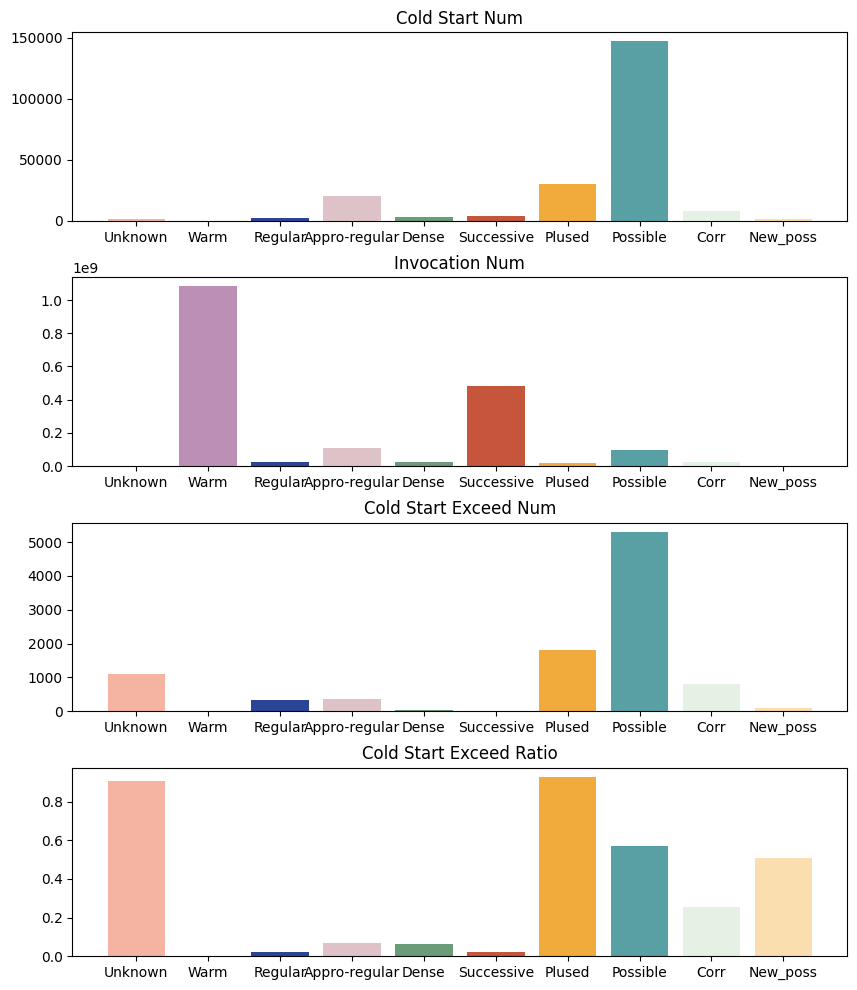

In [84]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 12))
plt.subplots_adjust(wspace=0, hspace=0.3)

ax1.bar(range(TYPE_NUM), 
        cold_num_per_type, 
        color=color_lst[:TYPE_NUM], 
        tick_label=label_lst
        )
ax1.set_title('Cold Start Num')

ax2.bar(range(TYPE_NUM), 
        invok_num_per_type, 
        color=color_lst[: TYPE_NUM], 
        tick_label=label_lst
        )
ax2.set_title('Invocation Num')

ax3.bar(range( TYPE_NUM), 
        cold_ratio_exceed_num, 
        color=color_lst[: TYPE_NUM],  
        tick_label=label_lst
        )
ax3.set_title('Cold Start Exceed Num')

ax4.bar(range( TYPE_NUM), 
        cold_ratio_exceed_rate, 
        color=color_lst[: TYPE_NUM],  
        tick_label=label_lst
        )
ax4.set_title('Cold Start Exceed Ratio')


plt.show()

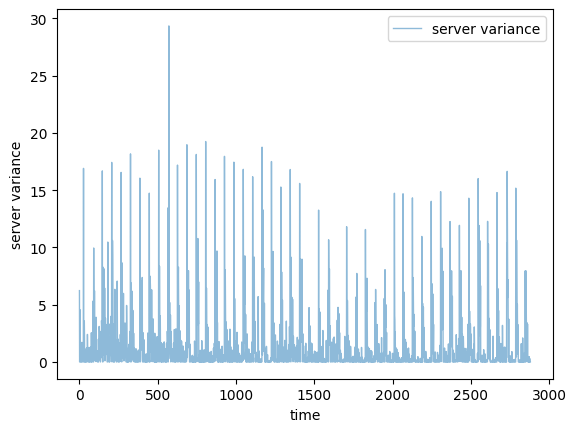

In [85]:

plt.plot(range(1440 * 2), var_lst, alpha=0.5, linewidth=1, label='server variance')

plt.legend()
plt.xlabel('time')
plt.ylabel('server variance')

plt.show()


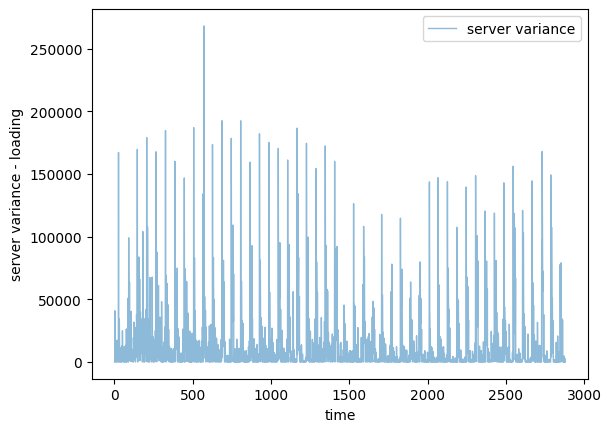

In [86]:

plt.plot(range(1440 * 2), var2_lst, alpha=0.5, linewidth=1, label='server variance')

plt.legend()
plt.xlabel('time')
plt.ylabel('server variance - loading')

plt.show()

In [87]:
with open(f"../result/server_std_variance_space_{curr_policy}_t11s6_random2_{cur_time}.json", "w") as wf:
    json.dump(var_lst, wf)

In [88]:
with open(f"../result/server_variance_loading_{curr_policy}_t11s6_random2_{cur_time}.json", "w") as wf:
    json.dump(var2_lst, wf)